In [1]:
import sklearn
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import seaborn as sns #for heatmap
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn import tree
from sklearn.utils import shuffle

In [3]:
from sklearn.semi_supervised import SelfTrainingClassifier

In [14]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pickle
import time

In [6]:
from sklearn.ensemble import BaggingClassifier
from semisupervised.TSVM import S3VM

# Overview of Previous Results

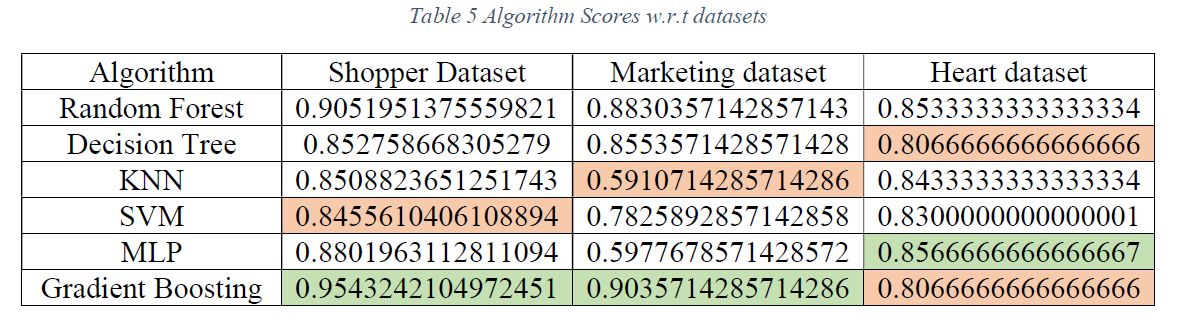

In [4]:
Image(filename='Algo_scores.png')

# 1. Self-Training Algorithm

## 1.1 Online shoppers Intention dataset

In [7]:
pre_shopper = pd.read_csv("datasets/preprocessed_online_shoppers_intention.csv")
pre_shopper = pre_shopper.drop("Unnamed: 0",axis="columns")
pre_shopper

,PageValues,ProductRelated,Month_Nov,BounceRates,Administrative,TrafficType_2,VisitorType_New_Visitor,Informational,TrafficType_3,SpecialDay,Month_May,TrafficType_13,TrafficType_1,Month_Mar,TrafficType_8,Revenue
0,-0.317178,-0.691003,0,3.667189,-0.696993,0,0,-0.396478,0,-0.308821,0,0,1,0,0,False
1,-0.317178,-0.668518,0,-0.457683,-0.696993,1,0,-0.396478,0,-0.308821,0,0,0,0,0,False
2,-0.317178,-0.691003,0,3.667189,-0.696993,0,0,-0.396478,1,-0.308821,0,0,0,0,0,False
3,-0.317178,-0.668518,0,0.573535,-0.696993,0,0,-0.396478,0,-0.308821,0,0,0,0,0,False
4,-0.317178,-0.488636,0,-0.045196,-0.696993,0,0,-0.396478,0,-0.308821,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.342125,0.478227,0,-0.310366,0.206173,0,0,-0.396478,0,-0.308821,0,0,1,0,0,False
12326,-0.317178,-0.601062,1,-0.457683,-0.696993,0,0,-0.396478,0,-0.308821,0,0,0,0,1,False
12327,-0.317178,-0.578577,1,1.261014,-0.696993,0,0,-0.396478,0,-0.308821,0,1,0,0,0,False
12328,-0.317178,-0.376210,1,-0.457683,0.507228,0,0,-0.396478,0,-0.308821,0,0,0,0,0,False


In [43]:
#Hyperparameter Tuning
def hyper_tune_gbe(datasets):
    oversample = RandomOverSampler(sampling_strategy='minority')
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])

        #Oversample only training data to avoid overfitting
        X_train, y_train = oversample.fit_resample(X_train, y_train)

        gbe = GradientBoostingClassifier()
        grid_params = {
            "n_estimators":[10,50,100,250,500],
            "max_depth":[1,3,5,7,9],
            "learning_rate":[0.001,0.01,0.1,0.5,1]
        }

        gs = GridSearchCV(gbe, grid_params, verbose = 1, cv=10, n_jobs = -1)
        g_res = gs.fit(X_train, y_train)
        if(i==0):
            print('Best parameters for Imbalanced dataset:\n', g_res.best_params_)
        elif(i==1):
            print('Best parameters for Oversampled dataset:\n', g_res.best_params_)
        else:
            print('Best parameters for RemMix dataset:\n', g_res.best_params_)


In [8]:
def ReMix (Xdf,ydf,target):
    frames=[]
    i=0
    batch_size=20

    oversample = RandomOverSampler(sampling_strategy='minority')

    while(i<len(Xdf)):
        X=Xdf[i:i+batch_size]
        y=ydf[i:i+batch_size]
        a = y.value_counts()
        if(len(a)==2):
            X, y = oversample.fit_resample(X, y)
        X[target]=y
        frames.append(X)
        i+=batch_size

    result = pd.concat(frames)

    for j in range(3):
        i=0
        frames=[]
        Xtemp= result.drop(target,axis="columns")
        ytemp= result[target]
        while(i<len(Xtemp)):
            X=Xtemp[i:i+batch_size]
            y=ytemp[i:i+batch_size]
            a = y.value_counts()
            if(len(a)==2):
                X, y = oversample.fit_resample(X, y)
            X[target]=y
            frames.append(X)
            i+=batch_size
        result = pd.concat(frames)
        result = shuffle(result)

    X = result.drop(target,axis="columns")
    y = result[target]
    
    X, y = oversample.fit_resample(X, y)
    
    return (X,y)

In [9]:
def return_datasets(df,target):
    dfc = df.copy()
    
    #Imbalanced
    X1 = dfc.drop(target,axis="columns")
    y1 = df[target]
    
    #Oversampled
    oversample = RandomOverSampler(sampling_strategy='minority')
    X2, y2 = oversample.fit_resample(X1, y1)
    
    #ReMix
    X3,y3 = ReMix(X1,y1,target)
    
    return ([[X1,y1],[X2,y2],[X3,y3]])

In [170]:
datasets = return_datasets(pre_shopper,"Revenue")

In [171]:
#Imbalanced
X1,y1 = datasets[0][0],datasets[0][1]
y1.value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

In [172]:
#Oversampled
X2,y2 = datasets[1][0],datasets[1][1]
y2.value_counts()

False    10422
True     10422
Name: Revenue, dtype: int64

In [173]:
#Remix
X3,y3 = datasets[2][0],datasets[2][1]
y3.value_counts()

False    18596
True     18596
Name: Revenue, dtype: int64

In [62]:
df = X2.copy()
df["Revenue"] = y2

df.to_csv('datasets/oversampled_shopper.csv')

In [63]:
df = X3.copy()
df["Revenue"] = y3

df.to_csv('datasets/Remix_shopper.csv')

### 1.1.1 Supervised

In [38]:
#hypertuning
hyper_tune_gbe(datasets)

Fitting 10 folds for each of 125 candidates, totalling 1250 fits
Best parameters for Imbalanced dataset:
 {'learning_rate': 1, 'max_depth': 9, 'n_estimators': 500}
Fitting 10 folds for each of 125 candidates, totalling 1250 fits
Best parameters for Oversampled dataset:
 {'learning_rate': 1, 'max_depth': 9, 'n_estimators': 500}
Fitting 10 folds for each of 125 candidates, totalling 1250 fits
Best parameters for RemMix dataset:
 {'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 500}


In [97]:
def get_scores_super(model,X1,y1):
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, stratify=y1)
    
    crossval_score = cross_val_score(model, X1, y1, cv=10)
    
    start_time = time.time()
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test,y_pred)
    
    rf_probs = model.predict_proba(X_test)
    rf_probs = rf_probs[:,1]
    rf_fpr,rf_tpr, _ = roc_curve(y_test,rf_probs)
    rf_auc = roc_auc_score(y_test,rf_probs)
    
    t=time.time() - start_time
    
    return([statistics.mean(crossval_score),f1,rf_auc,rf_fpr,rf_tpr,t])

In [174]:
#imbalanced
gbe = GradientBoostingClassifier(learning_rate= 1, max_depth= 9, n_estimators= 500)
imbal = get_scores_super(gbe,X1,y1)

#oversampled
gbe = GradientBoostingClassifier(learning_rate= 1, max_depth= 9, n_estimators= 500)
over = get_scores_super(gbe,X2,y2)

#ReMix
gbe = GradientBoostingClassifier(learning_rate= 0.5, max_depth= 9, n_estimators= 500)
remix = get_scores_super(gbe,X3,y3)

In [46]:
print("Average 10-fold Cross-val scores: ")
print("Imbalanced Data: ", imbal[0])
print("Oversampled Data: ", over[0])
print("Remix Data: ", remix[0])

print("\n\nF1-scores: ")
print("Imbalanced Data: ", imbal[1])
print("Oversampled Data: ", over[1])
print("Remix Data: ", remix[1])

Average 10-fold Cross-val scores: 
Imbalanced Data:  0.8479318734793188
Oversampled Data:  0.9551870365511813
Remix Data:  0.9803052258353854


F1-scores: 
Imbalanced Data:  0.5967153284671532
Oversampled Data:  0.9473846153846155
Remix Data:  0.9761523402740702


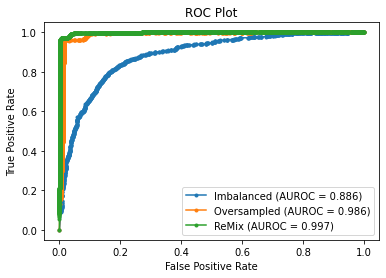

In [47]:
plt.plot(imbal[3], imbal[4], marker='.', label='Imbalanced (AUROC = %0.3f)' % imbal[2])
plt.plot(over[3], over[4], marker='.', label='Oversampled (AUROC = %0.3f)' % over[2])
plt.plot(remix[3], remix[4], marker='.', label='ReMix (AUROC = %0.3f)' % remix[2])
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

8.485251188278198 13.226993083953857 22.557647228240967


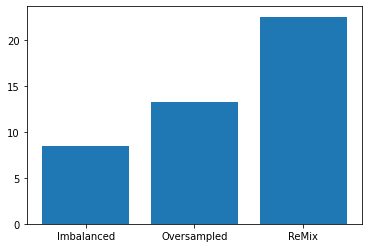

In [101]:
x = np.arange(3)
plt.bar(x, height=[imbal[5],over[5],remix[5]])
plt.xticks(x, ['Imbalanced','Oversampled','ReMix'])
print(imbal[5],over[5],remix[5])

### 1.1.2 Semi-Supervised

In [22]:
over_shopper = pd.read_csv("datasets/oversampled_shopper.csv")
remix_shopper = pd.read_csv("datasets/Remix_shopper.csv")

In [23]:
over_shopper.columns


Index(['Unnamed: 0', 'PageValues', 'ProductRelated', 'Month_Nov',
       'BounceRates', 'Administrative', 'TrafficType_2',
       'VisitorType_New_Visitor', 'Informational', 'TrafficType_3',
       'SpecialDay', 'Month_May', 'TrafficType_13', 'TrafficType_1',
       'Month_Mar', 'TrafficType_8', 'Revenue'],
      dtype='object')

In [24]:
over_shopper = over_shopper.drop('Unnamed: 0', axis="columns")
remix_shopper = remix_shopper.drop('Unnamed: 0', axis="columns")

In [25]:
X1 = pre_shopper.drop("Revenue",axis="columns")
y1 = pre_shopper["Revenue"]

X2 = over_shopper.drop("Revenue",axis="columns")
y2 = over_shopper["Revenue"]

X3 = remix_shopper.drop("Revenue",axis="columns")
y3 = remix_shopper["Revenue"]

datasets= [[X1,y1],[X2,y2],[X3,y3]]

In [30]:
def get_scores_semi(model, datasets, target, percent):
    scores = []
    for i in range(len(datasets)):
        if(i==0):
            print("Working on Imbalanced")
        elif(i==1):
            print("Working on Oversampled")
        else:
            print("Working on Remix")
        
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])
        
        df = X_train
        df[target] = y_train
        df[target] = df[target].replace([True,False],[1,0])
        df = shuffle(df)
        df = df.reset_index(drop=True)
        
        one_counter=0
        zero_counter=0
        if(percent<0.5):
            for j in range(int(len(df)*percent)):
                df[target][j] = -1
        else:
            for j in range(len(df)):
                if(df[target][j]==1):
                    if(one_counter<int((1-percent)*len(df)/2)):
                        one_counter+=1
                    else:
                        df[target][j]=-1
                else:
                    if(zero_counter<int((1-percent)*len(df)/2)):
                        zero_counter+=1
                    else:
                        df[target][j]=-1
        
        df = shuffle(df)
        
        if(i==0):
            model = GradientBoostingClassifier(learning_rate= 1, max_depth= 9, n_estimators= 500)
        
        elif(i==1):
            model = GradientBoostingClassifier(learning_rate= 1, max_depth= 9, n_estimators= 500)
            
        else:
            model = GradientBoostingClassifier(learning_rate= 0.5, max_depth= 9, n_estimators= 500)
            
        
        start_time = time.time()
        
        self_training_model = SelfTrainingClassifier(model)
        X = df.drop(target,axis="columns")
        y = df[target]
        
        self_training_model.fit(X,y)
        
        y_pred = self_training_model.predict(X_test)
        f1 = f1_score(y_test,y_pred)

        rf_probs = self_training_model.predict_proba(X_test)
        rf_probs = rf_probs[:,1]
        rf_fpr,rf_tpr, _ = roc_curve(y_test,rf_probs)
        rf_auc = roc_auc_score(y_test,rf_probs)
        
        acc = self_training_model.score(X_test,y_test)
        
        t = time.time()-start_time
        print("Completed after: ",t," seconds")
        
        scores.append([acc,f1,rf_auc,rf_fpr,rf_tpr,t])
        
    return scores

In [31]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_semi(GradientBoostingClassifier(),datasets, "Revenue", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Completed after:  35.639607429504395  seconds
Working on Oversampled
Completed after:  74.01523947715759  seconds
Working on Remix
Completed after:  158.0514988899231  seconds
Unlabelled percent:  20.0
Working on Imbalanced
Completed after:  64.4496591091156  seconds
Working on Oversampled
Completed after:  94.86489272117615  seconds
Working on Remix
Completed after:  167.069482088089  seconds
Unlabelled percent:  50.0
Working on Imbalanced
Completed after:  37.0964629650116  seconds
Working on Oversampled
Completed after:  88.13027167320251  seconds
Working on Remix
Completed after:  112.83128261566162  seconds
Unlabelled percent:  90.0
Working on Imbalanced
Completed after:  27.548362255096436  seconds
Working on Oversampled
Completed after:  51.57089924812317  seconds
Working on Remix
Completed after:  118.14949917793274  seconds
Unlabelled percent:  95.0
Working on Imbalanced
Completed after:  28.255443334579468  seconds
Working on Ov


----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy :
Imbalanced:  0.8810489321438226
Oversampled:  0.9507515190278222
ReMix:  0.9741208295761947

F1-scores:
Imbalanced:  0.5955882352941178
Oversampled:  0.9525277435265104
ReMix:  0.9744502804237515




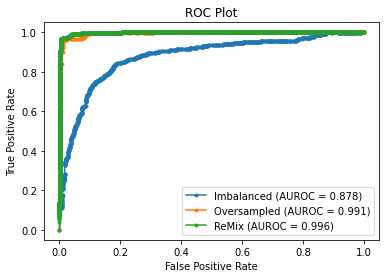


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy :
Imbalanced:  0.869153825358205
Oversampled:  0.9440358170770706
ReMix:  0.9715960324616771

F1-scores:
Imbalanced:  0.573943661971831
Oversampled:  0.9463519313304721
ReMix:  0.9719626168224299




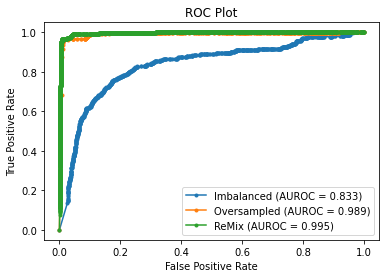


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy :
Imbalanced:  0.8553663152203298
Oversampled:  0.9224496322353694
ReMix:  0.9568981064021641

F1-scores:
Imbalanced:  0.6353101567825494
Oversampled:  0.9252120277563609
ReMix:  0.9575940383250533




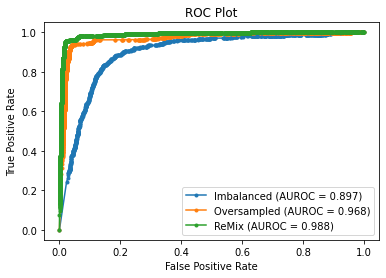


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy :
Imbalanced:  0.851581508515815
Oversampled:  0.85865046370323
ReMix:  0.8999098286744815

F1-scores:
Imbalanced:  0.6298044504383008
Oversampled:  0.860479797979798
ReMix:  0.9012103951584193




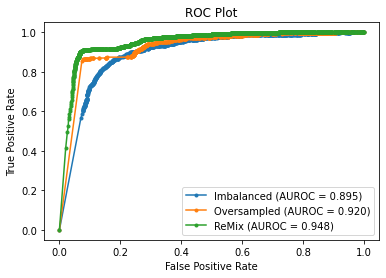


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy :
Imbalanced:  0.8648283319816167
Oversampled:  0.837863767188999
ReMix:  0.8794409377817853

F1-scores:
Imbalanced:  0.5136186770428015
Oversampled:  0.8368725868725868
ReMix:  0.8812927284027346




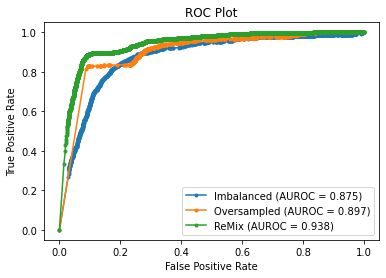

In [32]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy :")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [33]:
file_name="self_shopper.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [196]:
open_file = open("self_shopper.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [166]:
def avg_roc(loaded_list):

    imbal_rf_fpr=[]
    imbal_rf_tpr=[]
    imbal_auroc=[]

    over_rf_fpr=[]
    over_rf_tpr=[]
    over_auroc=[]

    remix_rf_fpr=[]
    remix_rf_tpr=[]
    remix_auroc=[]

    for i in range(len(unlabelled_percent)):

        imbal_rf_fpr.append(loaded_list[i][0][3])
        imbal_rf_tpr.append(loaded_list[i][0][4])
        imbal_auroc.append(loaded_list[i][0][2])

        over_rf_fpr.append(loaded_list[i][1][3])
        over_rf_tpr.append(loaded_list[i][1][4])
        over_auroc.append(loaded_list[i][1][2])

        remix_rf_fpr.append(loaded_list[i][2][3])
        remix_rf_tpr.append(loaded_list[i][2][4])
        remix_auroc.append(loaded_list[i][2][2])


    imbal_min_max=[]

    over_min_max=[]

    remix_min_max=[]

    for i in range(len(remix_rf_fpr)):
        imbal_min_max.append([min(imbal_rf_fpr[i]),max(imbal_rf_fpr[i])])
        over_min_max.append([min(over_rf_fpr[i]),max(over_rf_fpr[i])])
        remix_min_max.append([min(remix_rf_fpr[i]),max(remix_rf_fpr[i])])

    imbal_new_x = []
    over_new_x=[]
    remix_new_x=[]

    for i in range(len(imbal_min_max)):
        imbal_new_x.append(np.linspace(imbal_min_max[i][0], imbal_min_max[i][1], 100))
        over_new_x.append(np.linspace(over_min_max[i][0], over_min_max[i][1], 100))
        remix_new_x.append(np.linspace(remix_min_max[i][0], remix_min_max[i][1], 100))

    imbal_new_y = []
    over_new_y= []
    remix_new_y= []

    for i in range(len(imbal_new_x)):
        imbal_new_y.append(np.interp(imbal_new_x[i], loaded_list[i][0][3], loaded_list[i][0][4]))
        over_new_y.append(np.interp(over_new_x[i], loaded_list[i][1][3], loaded_list[i][1][4]))
        remix_new_y.append(np.interp(remix_new_x[i], loaded_list[i][2][3], loaded_list[i][2][4]))

    imbal_mid_x = [0 for i in range(100)]
    over_mid_x = [0 for i in range(100)]
    remix_mid_x = [0 for i in range(100)]

    imbal_mid_y = [0 for i in range(100)]
    over_mid_y = [0 for i in range(100)]
    remix_mid_y = [0 for i in range(100)]

    for i in range(100):
        temp_imbal_x=[]
        temp_over_x=[]
        temp_remix_x=[]

        temp_imbal_y=[]
        temp_over_y=[]
        temp_remix_y=[]

        for j in range(len(imbal_new_x)):
            temp_imbal_x.append(imbal_new_x[j][i])
            temp_over_x.append(over_new_x[j][i])
            temp_remix_x.append(remix_new_x[j][i])

            temp_imbal_y.append(imbal_new_y[j][i])
            temp_over_y.append(over_new_y[j][i])
            temp_remix_y.append(remix_new_y[j][i])

        imbal_mid_x[i] = np.mean(temp_imbal_x)
        over_mid_x[i] = np.mean(temp_over_x)
        remix_mid_x[i] = np.mean(temp_remix_x)

        imbal_mid_y[i] = np.mean(temp_imbal_y)
        over_mid_y[i] = np.mean(temp_over_y)
        remix_mid_y[i] = np.mean(temp_remix_y)



    plt.plot(imbal_mid_x, imbal_mid_y, marker='.', label='Imbalanced (Avg AUROC = %0.3f)' % statistics.mean(imbal_auroc))
    plt.plot(over_mid_x, over_mid_y, marker='.', label='Oversampled (AUROC = %0.3f)' % statistics.mean(over_auroc))
    plt.plot(remix_mid_x, remix_mid_y, marker='.', label='ReMix (AUROC = %0.3f)' % statistics.mean(remix_auroc))
    # Title
    plt.title('Averaging ROC Plot over various levels on unlabelled data')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

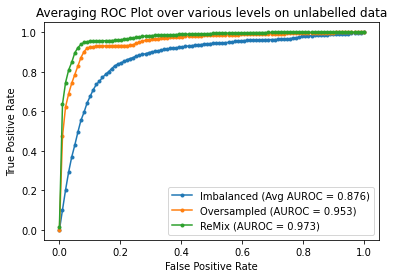

In [167]:
avg_roc(loaded_list)

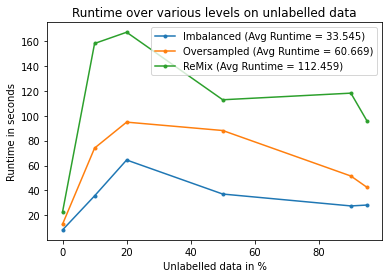

In [175]:
t_imbal = [imbal[5]]
t_over=[over[5]]
t_remix=[remix[5]]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [0,10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

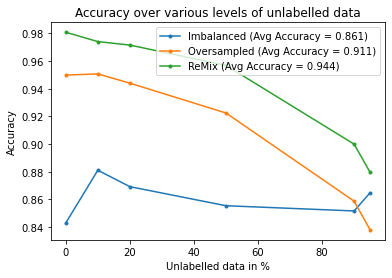

In [198]:
def gplotter(imbal,over,remix,title,xlabel,ylabel,loaded_list,x,val,ins):
    acc_imbal = imbal
    acc_over= over
    acc_remix= remix

    for i in range(len(loaded_list)):
        acc_imbal.append(loaded_list[i][0][val])
        acc_over.append(loaded_list[i][1][val])
        acc_remix.append(loaded_list[i][2][val])

    plt.plot(x, acc_imbal, marker='.', label='Imbalanced (Avg ' + ins + ' = %0.3f)' % statistics.mean(acc_imbal))
    plt.plot(x, acc_over, marker='.', label='Oversampled (Avg ' + ins + ' = %0.3f)' % statistics.mean(acc_over))
    plt.plot(x, acc_remix, marker='.', label='ReMix (Avg ' + ins + ' = %0.3f)' % statistics.mean(acc_remix))
    # Title
    plt.title(title)
    # Axis labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()
    
gplotter([imbal[0]],[over[0]],[remix[0]],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")


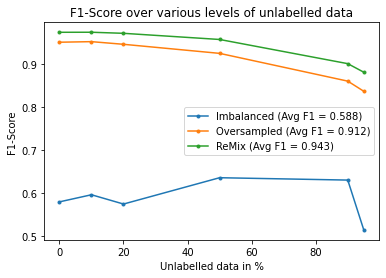

In [199]:
gplotter([imbal[1]],[over[1]],[remix[1]],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

## 1.2 Marketing Dataset

In [102]:
pre_market = pd.read_csv("datasets/preprocessed_marketing.csv")
pre_market = pre_market.drop("Unnamed: 0",axis="columns")
pre_market

,MntSweetProducts,Response,AcceptedCmp3,MntFishProducts,NumDealsPurchases,Education_Graduation,AcceptedCmp2,Education_Basic,AcceptedCmp5,ID,...,NumWebPurchases,Income,Year_Birth,Marital_Status_Divorced,Education_PhD,Marital_Status_Widow,Education_Master,MntFruits,Marital_Status_Single,Education_2n Cycle
0,1.476500,1,0,2.462147,0.349414,1,0,0,0,5524,...,1.409304,0.235327,1957,0,0,0,0,1.551577,1,0
1,-0.631503,0,0,-0.650449,-0.168236,1,0,0,0,2174,...,-1.110409,-0.235826,1954,0,0,0,0,-0.636301,1,0
2,-0.146905,0,0,1.345274,-0.685887,1,0,0,0,4141,...,1.409304,0.773633,1965,0,0,0,0,0.570804,0,0
3,-0.583043,0,0,-0.503974,-0.168236,1,0,0,0,6182,...,-0.750450,-1.022732,1984,0,0,0,0,-0.560857,0,0
4,-0.001525,0,0,0.155164,1.384715,0,0,0,0,5324,...,0.329427,0.241519,1981,0,1,0,0,0.419916,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2.203398,0,0,0.081926,-0.168236,1,0,0,0,10870,...,1.769263,0.358568,1967,0,0,0,0,0.419916,0,0
2236,-0.655733,0,0,-0.687068,2.420015,0,0,0,0,4001,...,1.409304,0.470064,1946,0,1,0,0,-0.661449,0,0
2237,-0.364974,0,0,-0.101168,-0.685887,1,0,0,0,7270,...,-0.750450,0.189106,1981,1,0,0,0,0.545656,0,0
2238,0.071165,0,0,0.777683,-0.168236,0,0,0,0,8235,...,0.689386,0.679035,1956,0,0,0,1,0.092992,0,0


In [35]:
pre_market["Teenhome"].value_counts()

No     1158
Yes    1082
Name: Teenhome, dtype: int64

In [103]:
pre_market["Teenhome"] = pre_market["Teenhome"].replace(["No","Yes"],[0,1])
pre_market["Teenhome"].value_counts()

0    1158
1    1082
Name: Teenhome, dtype: int64

In [104]:
datasets = return_datasets(pre_market,"Teenhome")

In [105]:
#Imbalanced
X1,y1 = datasets[0][0],datasets[0][1]
y1.value_counts()

0    1158
1    1082
Name: Teenhome, dtype: int64

In [106]:
#Oversampled
X2,y2 = datasets[1][0],datasets[1][1]
y2.value_counts()

0    1158
1    1158
Name: Teenhome, dtype: int64

In [107]:
#Remix
X3,y3 = datasets[2][0],datasets[2][1]
y3.value_counts()

0    2128
1    2128
Name: Teenhome, dtype: int64

In [50]:
df = X2.copy()
df["Teenhome"] = y2

df.to_csv('datasets/oversampled_market.csv')

In [51]:
df = X3.copy()
df["Teenhome"] = y3

df.to_csv('datasets/Remix_market.csv')

In [52]:
#hypertuning
hyper_tune_gbe(datasets)

Fitting 10 folds for each of 125 candidates, totalling 1250 fits
Best parameters for Imbalanced dataset:
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250}
Fitting 10 folds for each of 125 candidates, totalling 1250 fits
Best parameters for Oversampled dataset:
 {'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 250}
Fitting 10 folds for each of 125 candidates, totalling 1250 fits
Best parameters for RemMix dataset:
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


In [108]:
#imbalanced
gbe = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 250)
imbal = get_scores_super(gbe,X1,y1)

#oversampled
gbe = GradientBoostingClassifier(learning_rate= 0.5, max_depth= 9, n_estimators= 250)
over = get_scores_super(gbe,X2,y2)

#ReMix
gbe = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 500)
remix = get_scores_super(gbe,X3,y3)

In [55]:
print("Average 10-fold Cross-val scores: ")
print("Imbalanced Data: ", imbal[0])
print("Oversampled Data: ", over[0])
print("Remix Data: ", remix[0])

print("\n\nF1-scores: ")
print("Imbalanced Data: ", imbal[1])
print("Oversampled Data: ", over[1])
print("Remix Data: ", remix[1])

Average 10-fold Cross-val scores: 
Imbalanced Data:  0.9022321428571429
Oversampled Data:  0.9071727123451262
Remix Data:  0.9667791342952275


F1-scores: 
Imbalanced Data:  0.8833592534992224
Oversampled Data:  0.9001490312965723
Remix Data:  0.9557796741660203


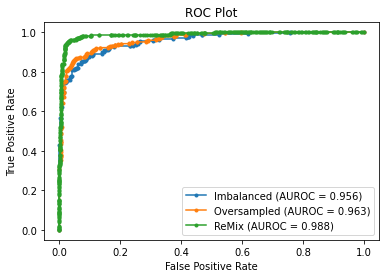

In [56]:
plt.plot(imbal[3], imbal[4], marker='.', label='Imbalanced (AUROC = %0.3f)' % imbal[2])
plt.plot(over[3], over[4], marker='.', label='Oversampled (AUROC = %0.3f)' % over[2])
plt.plot(remix[3], remix[4], marker='.', label='ReMix (AUROC = %0.3f)' % remix[2])
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

0.7091362476348877 2.6722936630249023 2.3741495609283447


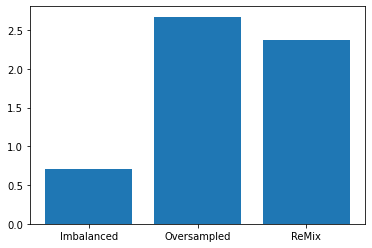

In [109]:
x = np.arange(3)
plt.bar(x, height=[imbal[5],over[5],remix[5]])
plt.xticks(x, ['Imbalanced','Oversampled','ReMix'])
print(imbal[5],over[5],remix[5])

### Semi-Supervised

In [38]:
def get_scores_semi(model, datasets, target, percent):
    scores = []
    for i in range(len(datasets)):
        if(i==0):
            print("Working on Imbalanced")
        elif(i==1):
            print("Working on Oversampled")
        else:
            print("Working on Remix")
        
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])
        
        df = X_train
        df[target] = y_train
        #df[target] = df[target].replace([True,False],[1,0])
        df = shuffle(df)
        
        df = df.reset_index(drop=True)
        
        one_counter=0
        zero_counter=0
        if(percent<0.5):
            for j in range(int(len(df)*percent)):
                df[target][j] = -1
        else:
            for j in range(len(df)):
                if(df[target][j]==1):
                    if(one_counter<int((1-percent)*len(df)/2)):
                        one_counter+=1
                    else:
                        df[target][j]=-1
                else:
                    if(zero_counter<int((1-percent)*len(df)/2)):
                        zero_counter+=1
                    else:
                        df[target][j]=-1
        
        df = shuffle(df)
        
        if(i==0):
            model = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 250)
        
        elif(i==1):
            model = GradientBoostingClassifier(learning_rate= 0.5, max_depth= 9, n_estimators= 250)
            
        else:
            model = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 500)
            
        
        start_time = time.time()
        
        self_training_model = SelfTrainingClassifier(model)
        X = df.drop(target,axis="columns")
        y = df[target]
        

        self_training_model.fit(X,y)
        
        y_pred = self_training_model.predict(X_test)
        f1 = f1_score(y_test,y_pred)

        rf_probs = self_training_model.predict_proba(X_test)
        rf_probs = rf_probs[:,1]
        rf_fpr,rf_tpr, _ = roc_curve(y_test,rf_probs)
        rf_auc = roc_auc_score(y_test,rf_probs)
        
        acc = self_training_model.score(X_test,y_test)
        
        t = time.time()-start_time

        scores.append([acc,f1,rf_auc,rf_fpr,rf_tpr,t])
        
    return scores

In [39]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_semi(GradientBoostingClassifier(),datasets, "Teenhome", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  20.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  50.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  90.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  95.0
Working on Imbalanced
Working on Oversampled
Working on Remix



----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy :
Imbalanced:  0.9002976190476191
Oversampled:  0.8848920863309353
ReMix:  0.9473264166001596

F1-scores:
Imbalanced:  0.8964451313755796
Oversampled:  0.8823529411764707
ReMix:  0.9472




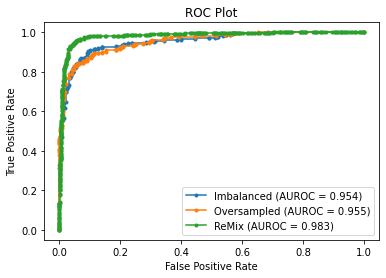


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy :
Imbalanced:  0.8973214285714286
Oversampled:  0.9050359712230216
ReMix:  0.9489225857940942

F1-scores:
Imbalanced:  0.8926905132192845
Oversampled:  0.9014925373134327
ReMix:  0.9488000000000001




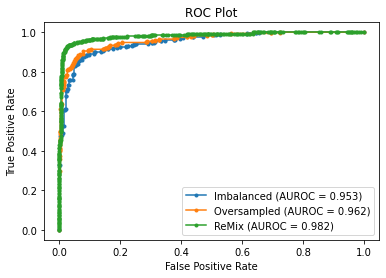


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy :
Imbalanced:  0.90625
Oversampled:  0.8733812949640288
ReMix:  0.9377494014365523

F1-scores:
Imbalanced:  0.9041095890410958
Oversampled:  0.8624999999999999
ReMix:  0.9376996805111821




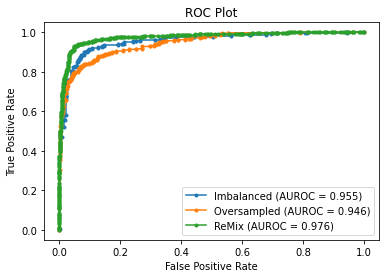


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy :
Imbalanced:  0.8363095238095238
Oversampled:  0.7712230215827338
ReMix:  0.8786911412609737

F1-scores:
Imbalanced:  0.8405797101449275
Oversampled:  0.7511737089201878
ReMix:  0.8795562599049128




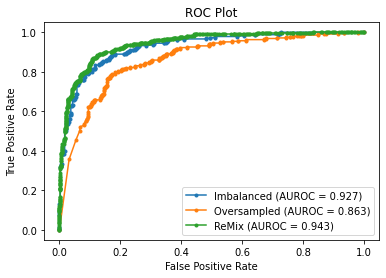


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy :
Imbalanced:  0.8348214285714286
Oversampled:  0.6935251798561151
ReMix:  0.8076616121308858

F1-scores:
Imbalanced:  0.8393632416787264
Oversampled:  0.6777609682299546
ReMix:  0.8167300380228136




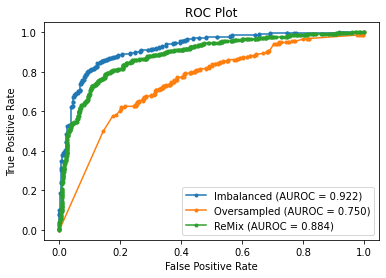

In [40]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy :")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [41]:
file_name="self_market.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [229]:
open_file = open("self_market.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

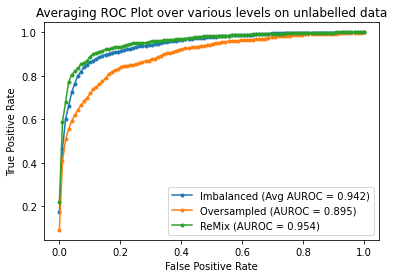

In [148]:
avg_roc(loaded_list)

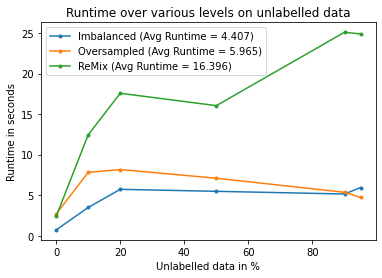

In [181]:
t_imbal = [0.7091362476348877]
t_over=[2.6722936630249023]
t_remix=[2.3741495609283447]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [0,10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

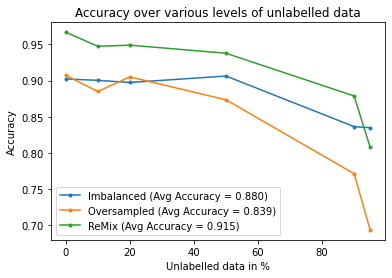

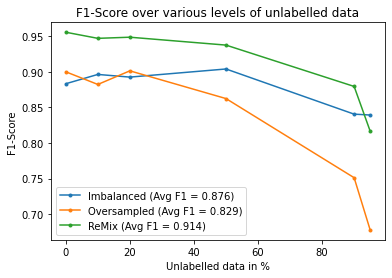

In [201]:
gplotter([0.9022321428571429],[0.9071727123451262],[0.9667791342952275],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")
gplotter([0.8833592534992224],[0.9001490312965723],[0.9557796741660203],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

## 1.3 Heart Dataset

In [42]:
pre_heart = pd.read_csv("datasets/preprocessed_heart.csv")
pre_heart = pre_heart.drop("Unnamed: 0",axis="columns")
pre_heart

,cp_1,oldpeak,ca_4,fbs_0,slope_0,thal_2,restecg_2,thalach,thal_1,ca_2,...,ca_3,cp_3,ca_1,sex_0,target,cp_2,cp_0,chol,trestbps,restecg_0
0,0,1.078769,0,0,1,0,0,0.014733,1,0,...,0,1,0,0,1,0,0,-0.265566,0.760273,1
1,0,2.111632,0,1,1,1,0,1.633884,0,0,...,0,0,0,0,1,1,0,0.062929,-0.092476,0
2,1,0.304121,0,1,0,1,0,0.977471,0,0,...,0,0,0,1,1,0,0,-0.825941,-0.092476,1
3,1,-0.212311,0,1,0,1,0,1.240037,0,0,...,0,0,0,0,1,0,0,-0.207596,-0.660975,0
4,0,-0.384455,0,1,0,1,0,0.583624,0,0,...,0,0,0,1,1,0,1,2.072551,-0.660975,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,-0.728743,0,1,0,0,0,-1.166810,0,0,...,0,0,0,1,0,0,1,-0.110980,0.476024,0
296,0,0.131977,0,1,0,0,0,-0.772962,0,0,...,0,1,0,0,0,0,0,0.333455,-1.229475,0
297,0,2.025560,0,0,0,0,0,-0.379115,0,1,...,0,0,0,0,0,0,1,-1.038498,0.703423,0
298,0,0.131977,0,1,0,0,0,-1.516897,0,0,...,0,0,1,0,0,0,1,-2.236541,-0.092476,0


In [43]:
pre_heart["target"].value_counts()

1    163
0    137
Name: target, dtype: int64

In [110]:
datasets = return_datasets(pre_heart,"target")

In [111]:
#Imbalanced
X1,y1 = datasets[0][0],datasets[0][1]
y1.value_counts()

1    163
0    137
Name: target, dtype: int64

In [112]:
#Oversampled
X2,y2 = datasets[1][0],datasets[1][1]
y2.value_counts()

0    163
1    163
Name: target, dtype: int64

In [113]:
#Remix
X3,y3 = datasets[2][0],datasets[2][1]
y3.value_counts()

0    229
1    229
Name: target, dtype: int64

In [70]:
df = X2.copy()
df["Teenhome"] = y2

df.to_csv('datasets/oversampled_heart.csv')

In [71]:
df = X3.copy()
df["Teenhome"] = y3

df.to_csv('datasets/Remix_heart.csv')

In [72]:
#Hyperparameter Tuning
def hyper_tune_rf(datasets):
    oversample = RandomOverSampler(sampling_strategy='minority')
    for i in range(3):
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])

        #Oversample only training data to avoid overfitting
        X_train, y_train = oversample.fit_resample(X_train, y_train)

        rf = RandomForestClassifier()
        grid_params = {
            'bootstrap': [True],
            'max_depth': [80, 90, 100, 110],
            'max_features': [2, 3, 4],
            'min_samples_leaf': [3, 4, 5],
            'min_samples_split': [8, 10, 12],
            'n_estimators': [100, 200, 300, 800, 900, 1000],
        }

        gs = GridSearchCV(rf, grid_params, verbose = 1, cv=10, n_jobs = -1)
        g_res = gs.fit(X_train, y_train)
        if(i==0):
            print('Best parameters for Imbalanced dataset:\n', g_res.best_params_)
        elif(i==1):
            print('Best parameters for Oversampled dataset:\n', g_res.best_params_)
        else:
            print('Best parameters for RemMix dataset:\n', g_res.best_params_)


In [73]:
#hypertuning
hyper_tune_rf(datasets)

Fitting 10 folds for each of 648 candidates, totalling 6480 fits
Best parameters for Imbalanced dataset:
 {'bootstrap': True, 'max_depth': 110, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
Best parameters for Oversampled dataset:
 {'bootstrap': True, 'max_depth': 90, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Fitting 10 folds for each of 648 candidates, totalling 6480 fits
Best parameters for RemMix dataset:
 {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}


In [114]:
#imbalanced
rf = RandomForestClassifier(bootstrap= True, max_depth= 110, max_features= 2, min_samples_leaf= 4, min_samples_split= 12, n_estimators= 100)
imbal = get_scores_super(rf,X1,y1)

#oversampled
rf = RandomForestClassifier(bootstrap= True, max_depth= 90, max_features= 2, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 200)
over = get_scores_super(rf,X2,y2)

#ReMix
rf = RandomForestClassifier(bootstrap= True, max_depth= 100, max_features= 3, min_samples_leaf= 3, min_samples_split= 8, n_estimators= 100)
remix = get_scores_super(rf,X3,y3)

In [115]:
print("Average 10-fold Cross-val scores: ")
print("Imbalanced Data: ", imbal[0])
print("Oversampled Data: ", over[0])
print("Remix Data: ", remix[0])

print("\n\nF1-scores: ")
print("Imbalanced Data: ", imbal[1])
print("Oversampled Data: ", over[1])
print("Remix Data: ", remix[1])

Average 10-fold Cross-val scores: 
Imbalanced Data:  0.8466666666666667
Oversampled Data:  0.8555871212121212
Remix Data:  0.9017874396135266


F1-scores: 
Imbalanced Data:  0.8041237113402061
Oversampled Data:  0.8799999999999999
Remix Data:  0.9


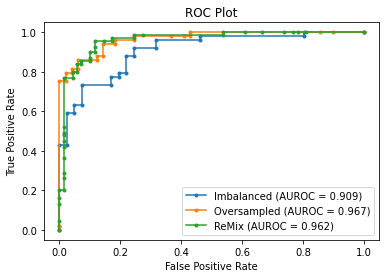

In [116]:
plt.plot(imbal[3], imbal[4], marker='.', label='Imbalanced (AUROC = %0.3f)' % imbal[2])
plt.plot(over[3], over[4], marker='.', label='Oversampled (AUROC = %0.3f)' % over[2])
plt.plot(remix[3], remix[4], marker='.', label='ReMix (AUROC = %0.3f)' % remix[2])
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

0.10934925079345703 0.2030773162841797 0.12466692924499512


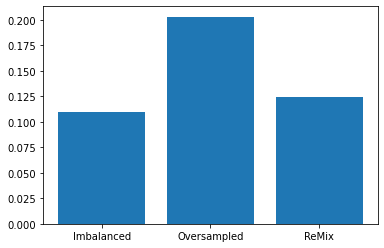

In [117]:
x = np.arange(3)
plt.bar(x, height=[imbal[5],over[5],remix[5]])
plt.xticks(x, ['Imbalanced','Oversampled','ReMix'])
print(imbal[5],over[5],remix[5])

### Semi-Supervised

In [54]:
def get_scores_semi(model, datasets, target, percent):
    scores = []
    for i in range(len(datasets)):
        if(i==0):
            print("Working on Imbalanced")
        elif(i==1):
            print("Working on Oversampled")
        else:
            print("Working on Remix")
        
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])
        
        df = X_train
        df[target] = y_train
        #df[target] = df[target].replace([True,False],[1,0])
        df = shuffle(df)
        
        df = df.reset_index(drop=True)
        
        one_counter=0
        zero_counter=0
        if(percent<0.5):
            for j in range(int(len(df)*percent)):
                df[target][j] = -1
        else:
            for j in range(len(df)):
                if(df[target][j]==1):
                    if(one_counter<int((1-percent)*len(df)/2)):
                        one_counter+=1
                    else:
                        df[target][j]=-1
                else:
                    if(zero_counter<int((1-percent)*len(df)/2)):
                        zero_counter+=1
                    else:
                        df[target][j]=-1
        
        df = shuffle(df)
        
        if(i==0):
            model = RandomForestClassifier(bootstrap= True, max_depth= 110, max_features= 2, min_samples_leaf= 4, min_samples_split= 12, n_estimators= 100)
        
        elif(i==1):
            model = RandomForestClassifier(bootstrap= True, max_depth= 90, max_features= 2, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 200)
            
        else:
            model = RandomForestClassifier(bootstrap= True, max_depth= 100, max_features= 3, min_samples_leaf= 3, min_samples_split= 8, n_estimators= 100)
            
        
        start_time = time.time()
        
        self_training_model = SelfTrainingClassifier(model)
        X = df.drop(target,axis="columns")
        y = df[target]
        

        self_training_model.fit(X,y)
        
        y_pred = self_training_model.predict(X_test)
        f1 = f1_score(y_test,y_pred)

        rf_probs = self_training_model.predict_proba(X_test)
        rf_probs = rf_probs[:,1]
        rf_fpr,rf_tpr, _ = roc_curve(y_test,rf_probs)
        rf_auc = roc_auc_score(y_test,rf_probs)
        
        t = time.time()-start_time
        
        acc = self_training_model.score(X_test,y_test)
        
        print("Completed in: ",t," seconds")
        scores.append([acc,f1,rf_auc,rf_fpr,rf_tpr,t])
        
    return scores

In [57]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_semi(RandomForestClassifier(),datasets, "target", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Completed in:  0.2770562171936035  seconds
Working on Oversampled
Completed in:  0.7507426738739014  seconds
Working on Remix
Completed in:  0.5927913188934326  seconds
Unlabelled percent:  20.0
Working on Imbalanced
Completed in:  0.279754638671875  seconds
Working on Oversampled
Completed in:  1.0988738536834717  seconds
Working on Remix
Completed in:  0.4009711742401123  seconds
Unlabelled percent:  50.0
Working on Imbalanced
Completed in:  0.8291275501251221  seconds
Working on Oversampled
Completed in:  1.4749977588653564  seconds
Working on Remix
Completed in:  0.5745697021484375  seconds
Unlabelled percent:  90.0
Working on Imbalanced
Completed in:  0.18221783638000488  seconds
Working on Oversampled
Completed in:  0.3732452392578125  seconds
Working on Remix
Completed in:  1.03853440284729  seconds
Unlabelled percent:  95.0
Working on Imbalanced
Completed in:  0.18796372413635254  seconds
Working on Oversampled
Completed in:  0.38


----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy:
Imbalanced:  0.8111111111111111
Oversampled:  0.7755102040816326
ReMix:  0.8705035971223022

F1-scores:
Imbalanced:  0.8411214953271028
Oversampled:  0.7843137254901962
ReMix:  0.8615384615384616




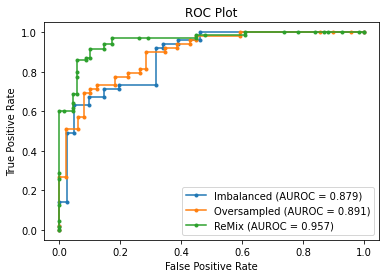


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy:
Imbalanced:  0.8333333333333334
Oversampled:  0.8571428571428571
ReMix:  0.8992805755395683

F1-scores:
Imbalanced:  0.8484848484848485
Oversampled:  0.8627450980392157
ReMix:  0.8970588235294117




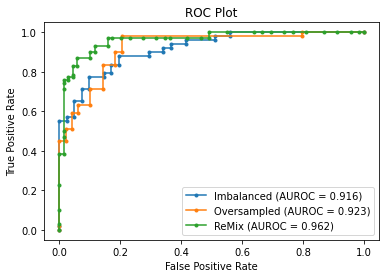


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy:
Imbalanced:  0.7888888888888889
Oversampled:  0.8163265306122449
ReMix:  0.8920863309352518

F1-scores:
Imbalanced:  0.822429906542056
Oversampled:  0.8333333333333333
ReMix:  0.8920863309352518




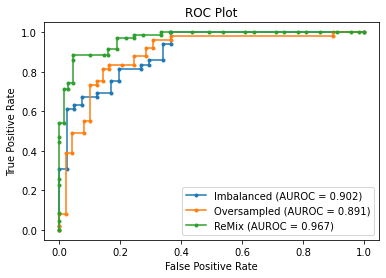


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy:
Imbalanced:  0.8111111111111111
Oversampled:  0.7959183673469388
ReMix:  0.8273381294964028

F1-scores:
Imbalanced:  0.8349514563106796
Oversampled:  0.8148148148148148
ReMix:  0.8518518518518519




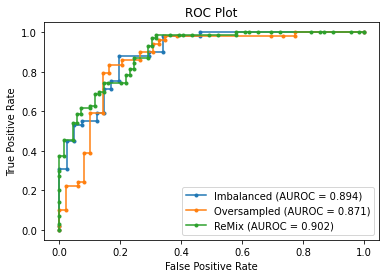


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy:
Imbalanced:  0.5444444444444444
Oversampled:  0.5
ReMix:  0.7697841726618705

F1-scores:
Imbalanced:  0.7050359712230216
Oversampled:  0.6666666666666666
ReMix:  0.8048780487804879




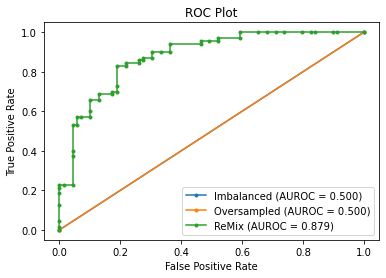

In [58]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy:")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [59]:
file_name="self_heart.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [202]:
open_file = open("self_heart.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

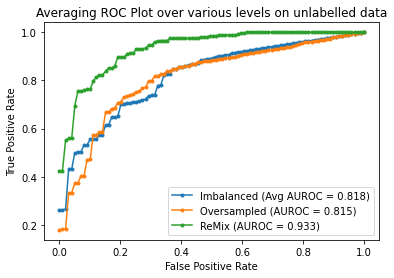

In [150]:
avg_roc(loaded_list)

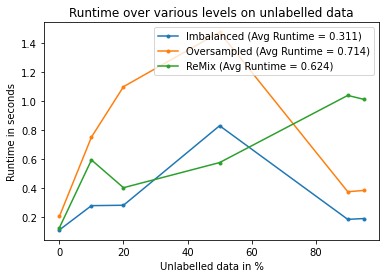

In [185]:
t_imbal = [0.10934925079345703]
t_over=[0.2030773162841797]
t_remix=[0.12466692924499512]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [0,10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

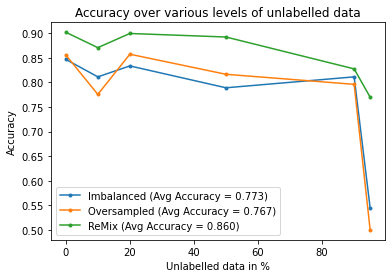

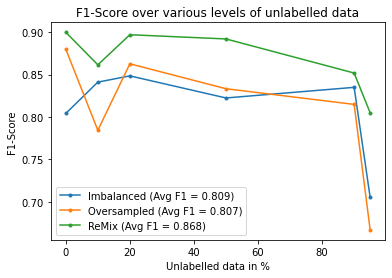

In [203]:
gplotter([0.8466666666666667],[0.8555871212121212],[0.9017874396135266],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")
gplotter([0.8041237113402061],[0.8799999999999999],[0.9],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

# Q2 Semi-Supervised ensembles

## 2.1 Shopper Dataset

In [60]:
datasets = return_datasets(pre_shopper,"Revenue")

In [61]:
for i in range(len(datasets)):
    datasets[i][1] = datasets[i][1].replace([True,False],[1,0])

In [62]:
def get_scores_semi(datasets, target, percent):
    scores = []
    for i in range(len(datasets)):
        if(i==0):
            print("Working on Imbalanced")
        elif(i==1):
            print("Working on Oversampled")
        else:
            print("Working on Remix")
        
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])
        
        df = X_train
        df[target] = y_train
        #df[target] = df[target].replace([True,False],[1,0])
        df = shuffle(df)
        
        df = df.reset_index(drop=True)
        #Create Unlabelled Dataset
        one_counter=0
        zero_counter=0
        if(percent<0.5):
            for j in range(int(len(df)*percent)):
                df[target][j] = -1
        else:
            for j in range(len(df)):
                if(df[target][j]==1):
                    if(one_counter<int((1-percent)*len(df)/2)):
                        one_counter+=1
                    else:
                        df[target][j]=-1
                else:
                    if(zero_counter<int((1-percent)*len(df)/2)):
                        zero_counter+=1
                    else:
                        df[target][j]=-1
        
        df = shuffle(df) #Created unlabelled dataset
        df = df.reset_index(drop=True)
        #Sampling with replacement
        df1 = df.sample(n=len(df), replace=True)
        df2 = df.sample(n=len(df), replace=True)
        df3 = df.sample(n=len(df), replace=True)
        
        if(i==0):
            model = GradientBoostingClassifier(learning_rate= 1, max_depth= 9, n_estimators= 500)
        
        elif(i==1):
            model = GradientBoostingClassifier(learning_rate= 1, max_depth= 9, n_estimators= 500)
            
        else:
            model = GradientBoostingClassifier(learning_rate= 0.5, max_depth= 9, n_estimators= 500)
        
        start_time = time.time()
    
        model1 = SelfTrainingClassifier(model)
        model2 = SelfTrainingClassifier(model)
        model3 = SelfTrainingClassifier(model)
        
        X1 = df1.drop(target,axis="columns")
        y1 = df1[target]
        
        X2 = df2.drop(target,axis="columns")
        y2 = df2[target]
        
        X3 = df2.drop(target,axis="columns")
        y3 = df2[target]
        
        
        #crossval_scores = cross_val_score(self_training_model, X, y, cv=10)
        
        model1.fit(X1,y1)
        model2.fit(X2,y2)
        model3.fit(X3,y3)
        
        #y_pred1 = model1.predict(datasets[i][0])
        #y_pred2 = model2.predict(datasets[i][0])
        #y_pred3 = model3.predict(datasets[i][0])
        
        y_pred1 = model1.predict(X_test)
        y_pred2 = model2.predict(X_test)
        y_pred3 = model3.predict(X_test)
        
        y_pred=[]
        for j in range(len(y_pred1)):
            if(y_pred1[j]+y_pred2[j]+y_pred3[j]<2):
                y_pred.append(0)
            else:
                y_pred.append(1)
        
        f1 = f1_score(y_test,y_pred)

        #rf_probs1 = model1.predict_proba(datasets[i][0])
        #rf_probs2 = model2.predict_proba(datasets[i][0])
        #rf_probs3 = model3.predict_proba(datasets[i][0])
        
        rf_probs1 = model1.predict_proba(X_test)
        rf_probs2 = model2.predict_proba(X_test)
        rf_probs3 = model3.predict_proba(X_test)
        
        
        rf_fpr1,rf_tpr1, _ = roc_curve(y_test,rf_probs1[:,1])
        rf_fpr2,rf_tpr2, _ = roc_curve(y_test,rf_probs2[:,1])
        rf_fpr3,rf_tpr3, _ = roc_curve(y_test,rf_probs3[:,1])
        
        min_a1_x, max_a1_x = min(rf_fpr1), max(rf_fpr1)
        min_a2_x, max_a2_x = min(rf_fpr2), max(rf_fpr2)
        min_a3_x, max_a3_x = min(rf_fpr3), max(rf_fpr3)

        new_a1_x = np.linspace(min_a1_x, max_a1_x, 100)
        new_a2_x = np.linspace(min_a2_x, max_a2_x, 100)
        new_a3_x = np.linspace(min_a3_x, max_a3_x, 100)

        new_a1_y = np.interp(new_a1_x, rf_fpr1, rf_tpr1)
        new_a2_y = np.interp(new_a2_x, rf_fpr2, rf_tpr2)
        new_a3_y = np.interp(new_a3_x, rf_fpr3, rf_tpr3)

        midx = [np.mean([new_a1_x[j], new_a2_x[j], new_a3_x[j]]) for j in range(100)]
        midy = [np.mean([new_a1_y[j], new_a2_y[j], new_a3_y[j]]) for j in range(100)]
        
        rf_auc1 = roc_auc_score(y_test,rf_probs1[:,1])
        rf_auc2 = roc_auc_score(y_test,rf_probs2[:,1])
        rf_auc3 = roc_auc_score(y_test,rf_probs3[:,1])
        rf_auc = (rf_auc1 + rf_auc2 + rf_auc3)/3
        correct=0
        
        y_test = y_test.reset_index(drop=True)
        for j in range(len(y_pred)):
            if(y_pred[j]==y_test[j]):
                correct+=1
        
        acc = (correct/len(y_pred))*100
        
        t = time.time()-start_time
        print("Training Ended, Total time: ",t," seconds")
        scores.append([acc,f1,rf_auc,midx,midy,t])
        
    return scores

In [63]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_semi(datasets, "Revenue", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Training Ended, Total time:  97.59294533729553  seconds
Working on Oversampled
Training Ended, Total time:  181.7932801246643  seconds
Working on Remix
Training Ended, Total time:  301.2724144458771  seconds
Unlabelled percent:  20.0
Working on Imbalanced
Training Ended, Total time:  104.51294088363647  seconds
Working on Oversampled
Training Ended, Total time:  175.21242260932922  seconds
Working on Remix
Training Ended, Total time:  359.2400686740875  seconds
Unlabelled percent:  50.0
Working on Imbalanced
Training Ended, Total time:  103.20397973060608  seconds
Working on Oversampled
Training Ended, Total time:  215.11024832725525  seconds
Working on Remix
Training Ended, Total time:  329.3960556983948  seconds
Unlabelled percent:  90.0
Working on Imbalanced
Training Ended, Total time:  65.6123857498169  seconds
Working on Oversampled
Training Ended, Total time:  106.78879165649414  seconds
Working on Remix
Training Ended, Total time: 


----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy:
Imbalanced:  87.86158421194918
Oversampled:  93.1244003837544
ReMix:  96.25101141778298

F1-scores:
Imbalanced:  0.5861751152073733
Oversampled:  0.9337033610854146
ReMix:  0.9630810092961487




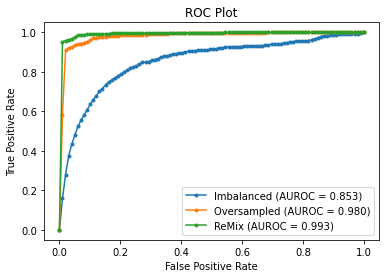


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy:
Imbalanced:  88.294133549608
Oversampled:  92.06907579149345
ReMix:  96.08019419221434

F1-scores:
Imbalanced:  0.5832531280076997
Oversampled:  0.923527597903176
ReMix:  0.9615655853314528




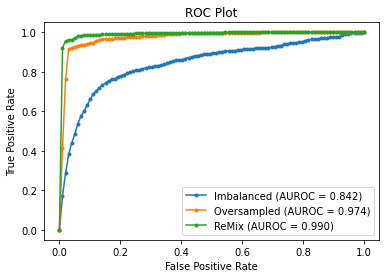


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy:
Imbalanced:  87.0235198702352
Oversampled:  89.59066197633516
ReMix:  93.95846444304594

F1-scores:
Imbalanced:  0.6439169139465876
Oversampled:  0.8986454927603923
ReMix:  0.9412279167395488




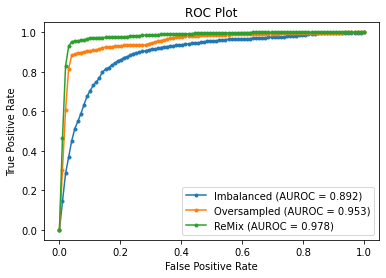


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy:
Imbalanced:  83.53609083536091
Oversampled:  84.33002878157978
ReMix:  88.92385147891756

F1-scores:
Imbalanced:  0.600655737704918
Oversampled:  0.8384970336189849
ReMix:  0.8916065458384655




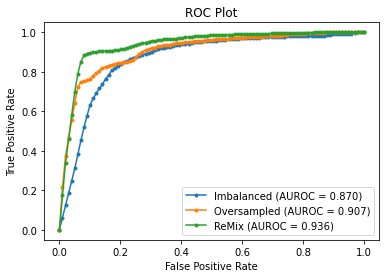


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy:
Imbalanced:  85.91511219248446
Oversampled:  78.38183562519987
ReMix:  86.82010249033534

F1-scores:
Imbalanced:  0.5310531053105311
Oversampled:  0.7356276886976927
ReMix:  0.8679517204107368




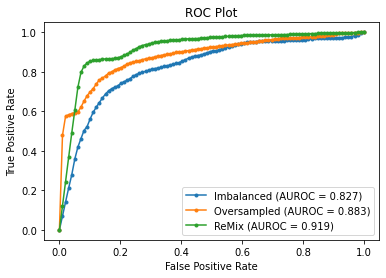

In [64]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy:")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [65]:
file_name="ensembles_shopper.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [206]:
open_file = open("ensembles_shopper.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

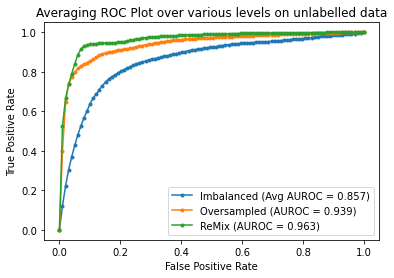

In [152]:
avg_roc(loaded_list)

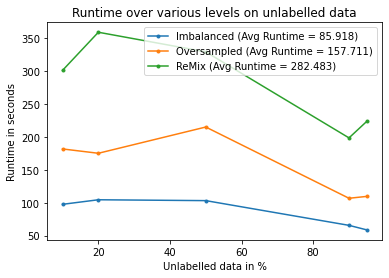

In [187]:
t_imbal = []
t_over=[]
t_remix=[]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

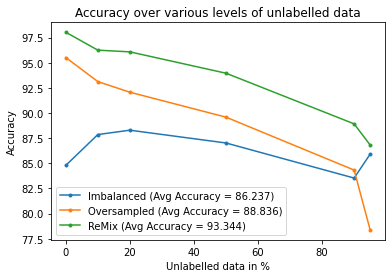

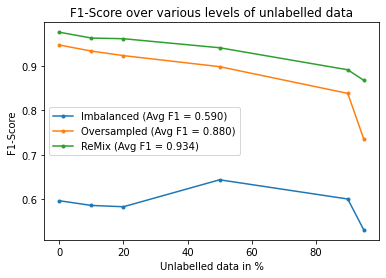

In [211]:
gplotter([84.79318734793188],[95.51870365511813],[98.03052258353854],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")
gplotter([0.5967153284671532],[0.9473846153846155],[0.9761523402740702],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

## 2.2 Market Dataset

In [66]:
datasets = return_datasets(pre_market,"Teenhome")

In [67]:
def get_scores_semi(datasets, target, percent):
    scores = []
    for i in range(len(datasets)):
        if(i==0):
            print("Working on Imbalanced")
        elif(i==1):
            print("Working on Oversampled")
        else:
            print("Working on Remix")
        
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])
        
        df = X_train
        df[target] = y_train
        #df[target] = df[target].replace([True,False],[1,0])
        df = shuffle(df)
        
        df = df.reset_index(drop=True)
        #Create Unlabelled Dataset
        one_counter=0
        zero_counter=0
        if(percent<0.5):
            for j in range(int(len(df)*percent)):
                df[target][j] = -1
        else:
            for j in range(len(df)):
                if(df[target][j]==1):
                    if(one_counter<int((1-percent)*len(df)/2)):
                        one_counter+=1
                    else:
                        df[target][j]=-1
                else:
                    if(zero_counter<int((1-percent)*len(df)/2)):
                        zero_counter+=1
                    else:
                        df[target][j]=-1
        
        df = shuffle(df) #Created unlabelled dataset
        df = df.reset_index(drop=True)
        #Sampling with replacement
        df1 = df.sample(n=len(df), replace=True)
        df2 = df.sample(n=len(df), replace=True)
        df3 = df.sample(n=len(df), replace=True)
        
        if(i==0):
            model = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 250)
        
        elif(i==1):
            model = GradientBoostingClassifier(learning_rate= 0.5, max_depth= 9, n_estimators= 250)
            
        else:
            model = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, n_estimators= 500)
        
        start_time = time.time()
    
        model1 = SelfTrainingClassifier(model)
        model2 = SelfTrainingClassifier(model)
        model3 = SelfTrainingClassifier(model)
        
        X1 = df1.drop(target,axis="columns")
        y1 = df1[target]
        
        X2 = df2.drop(target,axis="columns")
        y2 = df2[target]
        
        X3 = df2.drop(target,axis="columns")
        y3 = df2[target]
        
        
        #crossval_scores = cross_val_score(self_training_model, X, y, cv=10)
        
        model1.fit(X1,y1)
        model2.fit(X2,y2)
        model3.fit(X3,y3)
        
        #y_pred1 = model1.predict(datasets[i][0])
        #y_pred2 = model2.predict(datasets[i][0])
        #y_pred3 = model3.predict(datasets[i][0])
        
        y_pred1 = model1.predict(X_test)
        y_pred2 = model2.predict(X_test)
        y_pred3 = model3.predict(X_test)
        
        y_pred=[]
        for j in range(len(y_pred1)):
            if(y_pred1[j]+y_pred2[j]+y_pred3[j]<2):
                y_pred.append(0)
            else:
                y_pred.append(1)
        
        f1 = f1_score(y_test,y_pred)

        rf_probs1 = model1.predict_proba(X_test)
        rf_probs2 = model2.predict_proba(X_test)
        rf_probs3 = model3.predict_proba(X_test)
        
        
        rf_fpr1,rf_tpr1, _ = roc_curve(y_test,rf_probs1[:,1])
        rf_fpr2,rf_tpr2, _ = roc_curve(y_test,rf_probs2[:,1])
        rf_fpr3,rf_tpr3, _ = roc_curve(y_test,rf_probs3[:,1])
        
        min_a1_x, max_a1_x = min(rf_fpr1), max(rf_fpr1)
        min_a2_x, max_a2_x = min(rf_fpr2), max(rf_fpr2)
        min_a3_x, max_a3_x = min(rf_fpr3), max(rf_fpr3)

        new_a1_x = np.linspace(min_a1_x, max_a1_x, 100)
        new_a2_x = np.linspace(min_a2_x, max_a2_x, 100)
        new_a3_x = np.linspace(min_a3_x, max_a3_x, 100)

        new_a1_y = np.interp(new_a1_x, rf_fpr1, rf_tpr1)
        new_a2_y = np.interp(new_a2_x, rf_fpr2, rf_tpr2)
        new_a3_y = np.interp(new_a3_x, rf_fpr3, rf_tpr3)

        midx = [np.mean([new_a1_x[j], new_a2_x[j], new_a3_x[j]]) for j in range(100)]
        midy = [np.mean([new_a1_y[j], new_a2_y[j], new_a3_y[j]]) for j in range(100)]
        
        rf_auc1 = roc_auc_score(y_test,rf_probs1[:,1])
        rf_auc2 = roc_auc_score(y_test,rf_probs2[:,1])
        rf_auc3 = roc_auc_score(y_test,rf_probs3[:,1])
        rf_auc = (rf_auc1 + rf_auc2 + rf_auc3)/3
        correct=0
        
        y_test = y_test.reset_index(drop=True)
        for j in range(len(y_pred)):
            if(y_pred[j]==y_test[j]):
                correct+=1
        
        acc = (correct/len(y_pred))*100
        
        t = time.time()-start_time
        print("Training Ended, Total time: ",t," seconds")
        scores.append([acc,f1,rf_auc,midx,midy,t])
        
    return scores

In [68]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_semi(datasets, "Teenhome", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Training Ended, Total time:  8.266634464263916  seconds
Working on Oversampled
Training Ended, Total time:  17.614508867263794  seconds
Working on Remix
Training Ended, Total time:  35.07257604598999  seconds
Unlabelled percent:  20.0
Working on Imbalanced
Training Ended, Total time:  11.07813048362732  seconds
Working on Oversampled
Training Ended, Total time:  19.130056381225586  seconds
Working on Remix
Training Ended, Total time:  38.82088565826416  seconds
Unlabelled percent:  50.0
Working on Imbalanced
Training Ended, Total time:  13.659833192825317  seconds
Working on Oversampled
Training Ended, Total time:  19.41569209098816  seconds
Working on Remix
Training Ended, Total time:  47.857364654541016  seconds
Unlabelled percent:  90.0
Working on Imbalanced
Training Ended, Total time:  11.694493293762207  seconds
Working on Oversampled
Training Ended, Total time:  11.53790020942688  seconds
Working on Remix
Training Ended, Total time:


----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy:
Imbalanced:  87.05357142857143
Oversampled:  89.49640287769785
ReMix:  93.94879751745539

F1-scores:
Imbalanced:  0.8621236133122028
Oversampled:  0.890881913303438
ReMix:  0.9407294832826747




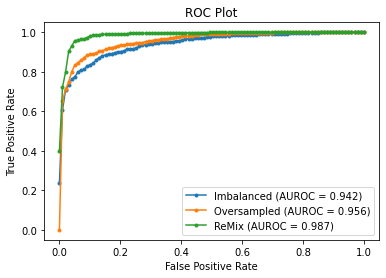


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy:
Imbalanced:  86.30952380952381
Oversampled:  89.49640287769785
ReMix:  93.32816136539954

F1-scores:
Imbalanced:  0.8584615384615384
Oversampled:  0.888888888888889
ReMix:  0.9328125




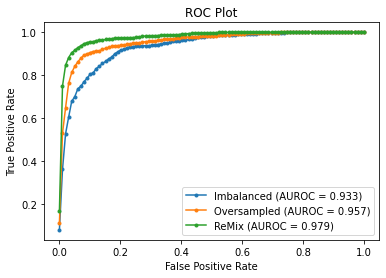


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy:
Imbalanced:  81.25
Oversampled:  82.73381294964028
ReMix:  92.39720713731575

F1-scores:
Imbalanced:  0.81524926686217
Oversampled:  0.8032786885245902
ReMix:  0.924031007751938




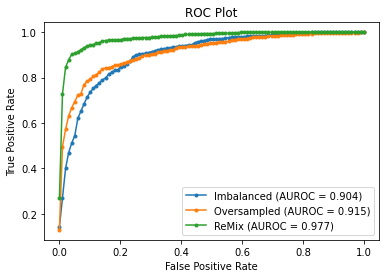


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy:
Imbalanced:  82.44047619047619
Oversampled:  72.0863309352518
ReMix:  86.26842513576416

F1-scores:
Imbalanced:  0.8238805970149254
Oversampled:  0.6891025641025641
ReMix:  0.8631090487238979




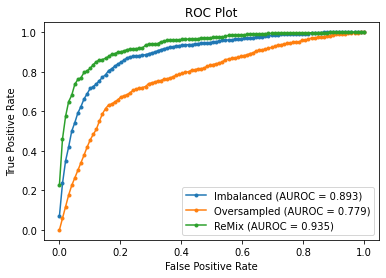


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy:
Imbalanced:  75.0
Oversampled:  71.94244604316546
ReMix:  76.18308766485647

F1-scores:
Imbalanced:  0.7423312883435582
Oversampled:  0.7169811320754716
ReMix:  0.7683018867924529




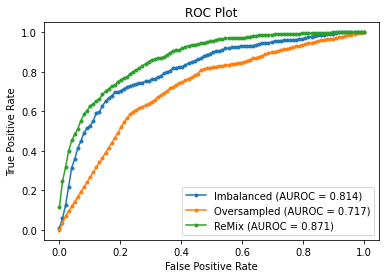

In [69]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy:")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [70]:
file_name="ensembles_market.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [212]:
open_file = open("ensembles_market.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

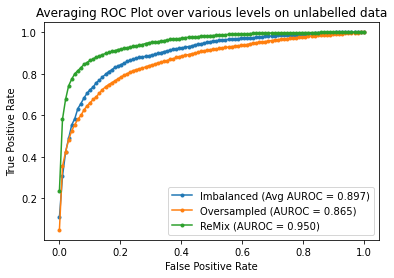

In [154]:
avg_roc(loaded_list)

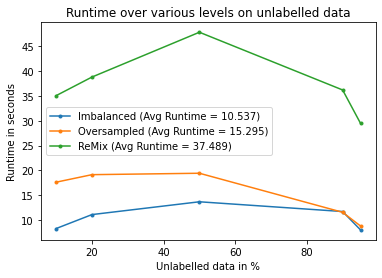

In [189]:
t_imbal = []
t_over=[]
t_remix=[]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

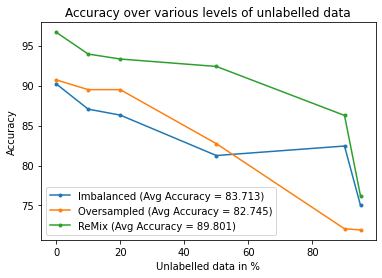

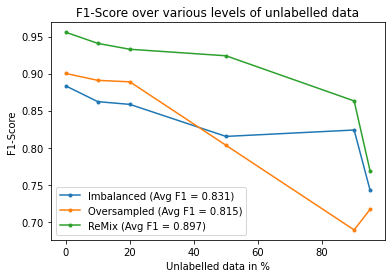

In [213]:
gplotter([90.22321428571429],[90.71727123451262],[96.67791342952275],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")
gplotter([0.8833592534992224],[0.9001490312965723],[0.9557796741660203],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

## 2.3 Heart Dataset

In [71]:
pre_heart = pd.read_csv("datasets/preprocessed_heart.csv")
pre_heart = pre_heart.drop("Unnamed: 0",axis="columns")
pre_heart

,cp_1,oldpeak,ca_4,fbs_0,slope_0,thal_2,restecg_2,thalach,thal_1,ca_2,...,ca_3,cp_3,ca_1,sex_0,target,cp_2,cp_0,chol,trestbps,restecg_0
0,0,1.078769,0,0,1,0,0,0.014733,1,0,...,0,1,0,0,1,0,0,-0.265566,0.760273,1
1,0,2.111632,0,1,1,1,0,1.633884,0,0,...,0,0,0,0,1,1,0,0.062929,-0.092476,0
2,1,0.304121,0,1,0,1,0,0.977471,0,0,...,0,0,0,1,1,0,0,-0.825941,-0.092476,1
3,1,-0.212311,0,1,0,1,0,1.240037,0,0,...,0,0,0,0,1,0,0,-0.207596,-0.660975,0
4,0,-0.384455,0,1,0,1,0,0.583624,0,0,...,0,0,0,1,1,0,1,2.072551,-0.660975,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,-0.728743,0,1,0,0,0,-1.166810,0,0,...,0,0,0,1,0,0,1,-0.110980,0.476024,0
296,0,0.131977,0,1,0,0,0,-0.772962,0,0,...,0,1,0,0,0,0,0,0.333455,-1.229475,0
297,0,2.025560,0,0,0,0,0,-0.379115,0,1,...,0,0,0,0,0,0,1,-1.038498,0.703423,0
298,0,0.131977,0,1,0,0,0,-1.516897,0,0,...,0,0,1,0,0,0,1,-2.236541,-0.092476,0


In [72]:
datasets = return_datasets(pre_heart,"target")

In [73]:
def get_scores_semi(datasets, target, percent):
    scores = []
    for i in range(len(datasets)):
        if(i==0):
            print("Working on Imbalanced")
        elif(i==1):
            print("Working on Oversampled")
        else:
            print("Working on Remix")
        
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])
        
        df = X_train
        df[target] = y_train
        #df[target] = df[target].replace([True,False],[1,0])
        df = shuffle(df)
        
        df = df.reset_index(drop=True)
        #Create Unlabelled Dataset
        one_counter=0
        zero_counter=0
        if(percent<0.5):
            for j in range(int(len(df)*percent)):
                df[target][j] = -1
        else:
            for j in range(len(df)):
                if(df[target][j]==1):
                    if(one_counter<int((1-percent)*len(df)/2)):
                        one_counter+=1
                    else:
                        df[target][j]=-1
                else:
                    if(zero_counter<int((1-percent)*len(df)/2)):
                        zero_counter+=1
                    else:
                        df[target][j]=-1
        
        df = shuffle(df) #Created unlabelled dataset
        df = df.reset_index(drop=True)
        #Sampling with replacement
        df1 = df.sample(n=len(df), replace=True)
        df2 = df.sample(n=len(df), replace=True)
        df3 = df.sample(n=len(df), replace=True)
        
        if(i==0):
            model = RandomForestClassifier()
        
        elif(i==1):
            model = RandomForestClassifier()
            
        else:
            model = RandomForestClassifier()
        
        start_time = time.time()
    
        model1 = SelfTrainingClassifier(model)
        model2 = SelfTrainingClassifier(model)
        model3 = SelfTrainingClassifier(model)
        
        X1 = df1.drop(target,axis="columns")
        y1 = df1[target]
        
        X2 = df2.drop(target,axis="columns")
        y2 = df2[target]
        
        X3 = df2.drop(target,axis="columns")
        y3 = df2[target]
        
        
        #crossval_scores = cross_val_score(self_training_model, X, y, cv=10)
        
        model1.fit(X1,y1)
        model2.fit(X2,y2)
        model3.fit(X3,y3)
        
        #y_pred1 = model1.predict(datasets[i][0])
        #y_pred2 = model2.predict(datasets[i][0])
        #y_pred3 = model3.predict(datasets[i][0])
        
        y_pred1 = model1.predict(X_test)
        y_pred2 = model2.predict(X_test)
        y_pred3 = model3.predict(X_test)
        
        y_pred=[]
        for j in range(len(y_pred1)):
            if(y_pred1[j]+y_pred2[j]+y_pred3[j]<2):
                y_pred.append(0)
            else:
                y_pred.append(1)
        
        f1 = f1_score(y_test,y_pred)

        #rf_probs1 = model1.predict_proba(datasets[i][0])
        #rf_probs2 = model2.predict_proba(datasets[i][0])
        #rf_probs3 = model3.predict_proba(datasets[i][0])
        
        rf_probs1 = model1.predict_proba(X_test)
        rf_probs2 = model2.predict_proba(X_test)
        rf_probs3 = model3.predict_proba(X_test)
        
        
        rf_fpr1,rf_tpr1, _ = roc_curve(y_test,rf_probs1[:,1])
        rf_fpr2,rf_tpr2, _ = roc_curve(y_test,rf_probs2[:,1])
        rf_fpr3,rf_tpr3, _ = roc_curve(y_test,rf_probs3[:,1])
        
        min_a1_x, max_a1_x = min(rf_fpr1), max(rf_fpr1)
        min_a2_x, max_a2_x = min(rf_fpr2), max(rf_fpr2)
        min_a3_x, max_a3_x = min(rf_fpr3), max(rf_fpr3)

        new_a1_x = np.linspace(min_a1_x, max_a1_x, 100)
        new_a2_x = np.linspace(min_a2_x, max_a2_x, 100)
        new_a3_x = np.linspace(min_a3_x, max_a3_x, 100)

        new_a1_y = np.interp(new_a1_x, rf_fpr1, rf_tpr1)
        new_a2_y = np.interp(new_a2_x, rf_fpr2, rf_tpr2)
        new_a3_y = np.interp(new_a3_x, rf_fpr3, rf_tpr3)

        midx = [np.mean([new_a1_x[j], new_a2_x[j], new_a3_x[j]]) for j in range(100)]
        midy = [np.mean([new_a1_y[j], new_a2_y[j], new_a3_y[j]]) for j in range(100)]
        
        rf_auc1 = roc_auc_score(y_test,rf_probs1[:,1])
        rf_auc2 = roc_auc_score(y_test,rf_probs2[:,1])
        rf_auc3 = roc_auc_score(y_test,rf_probs3[:,1])
        rf_auc = (rf_auc1 + rf_auc2 + rf_auc3)/3
        correct=0
        
        y_test = y_test.reset_index(drop=True)
        for j in range(len(y_pred)):
            if(y_pred[j]==y_test[j]):
                correct+=1
        
        acc = (correct/len(y_pred))*100
        
        t = time.time()-start_time
        print("Training Ended, Total time: ",t," seconds")
        scores.append([acc,f1,rf_auc,midx,midy,t])
        
    return scores

In [74]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_semi(datasets, "Teenhome", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Training Ended, Total time:  1.0264036655426025  seconds
Working on Oversampled
Training Ended, Total time:  1.2031147480010986  seconds
Working on Remix
Training Ended, Total time:  1.2586195468902588  seconds
Unlabelled percent:  20.0
Working on Imbalanced
Training Ended, Total time:  1.2811906337738037  seconds
Working on Oversampled
Training Ended, Total time:  1.2067303657531738  seconds
Working on Remix
Training Ended, Total time:  1.0468239784240723  seconds
Unlabelled percent:  50.0
Working on Imbalanced
Training Ended, Total time:  1.8801274299621582  seconds
Working on Oversampled
Training Ended, Total time:  1.9774532318115234  seconds
Working on Remix
Training Ended, Total time:  1.758772850036621  seconds
Unlabelled percent:  90.0
Working on Imbalanced
Training Ended, Total time:  2.437378168106079  seconds
Working on Oversampled
Training Ended, Total time:  2.614614963531494  seconds
Working on Remix
Training Ended, Total ti


----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy:
Imbalanced:  82.22222222222221
Oversampled:  78.57142857142857
ReMix:  93.00699300699301

F1-scores:
Imbalanced:  0.8367346938775511
Oversampled:  0.8037383177570093
ReMix:  0.927536231884058




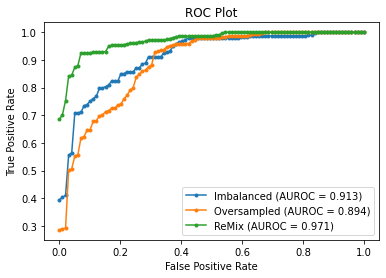


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy:
Imbalanced:  83.33333333333334
Oversampled:  84.6938775510204
ReMix:  88.81118881118881

F1-scores:
Imbalanced:  0.8484848484848485
Oversampled:  0.8484848484848485
ReMix:  0.8873239436619719




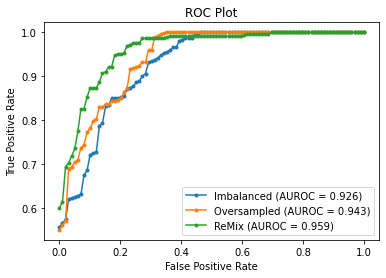


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy:
Imbalanced:  82.22222222222221
Oversampled:  86.73469387755102
ReMix:  87.41258741258741

F1-scores:
Imbalanced:  0.84
Oversampled:  0.8571428571428572
ReMix:  0.8714285714285713




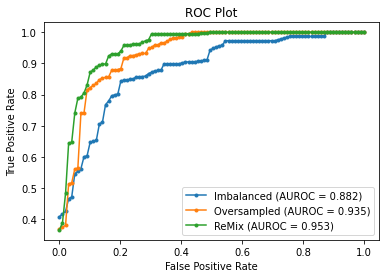


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy:
Imbalanced:  77.77777777777779
Oversampled:  72.44897959183673
ReMix:  80.41958041958041

F1-scores:
Imbalanced:  0.7619047619047618
Oversampled:  0.6493506493506493
ReMix:  0.7812499999999999




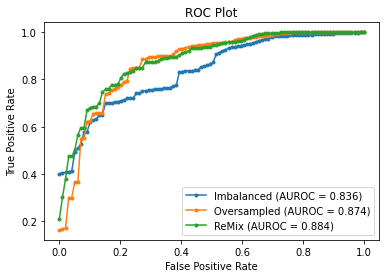


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy:
Imbalanced:  72.22222222222221
Oversampled:  72.44897959183673
ReMix:  72.02797202797203

F1-scores:
Imbalanced:  0.7524752475247524
Oversampled:  0.7610619469026548
ReMix:  0.7619047619047619




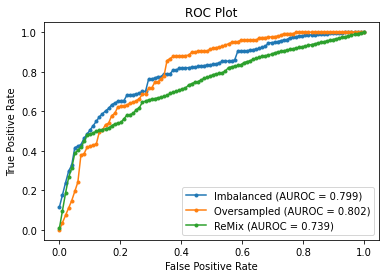

In [75]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy:")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [76]:
file_name="ensembles_heart.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [214]:
open_file = open("ensembles_heart.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

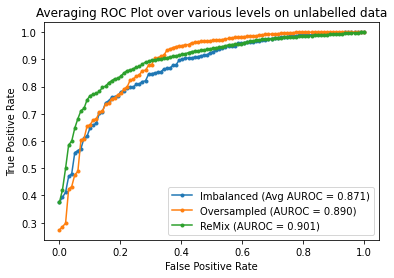

In [156]:
avg_roc(loaded_list)

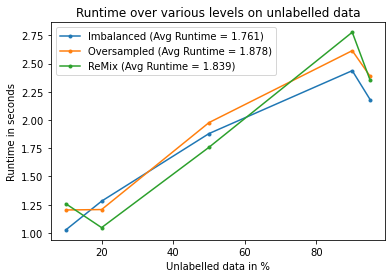

In [191]:
t_imbal = []
t_over=[]
t_remix=[]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

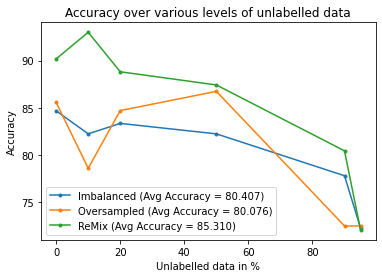

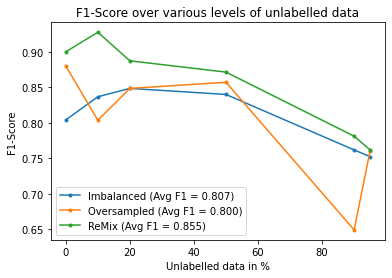

In [215]:
gplotter([84.66666666666667],[85.55871212121212],[90.17874396135266],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")
gplotter([0.8041237113402061],[0.8799999999999999],[0.9],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

# Q3 Intrinsic semi-supervised learning method
## SVM maximum-margin (s3vm)

### Shopper Dataset

In [77]:
datasets = return_datasets(pre_shopper,"Revenue")

In [78]:
for i in range(len(datasets)):
    datasets[i][1] = datasets[i][1].replace([True,False],[1,0])

In [79]:
def get_scores_s3vm(datasets, target, percent):
    scores = []
    for i in range(len(datasets)):
        if(i==0):
            print("Working on Imbalanced")
        elif(i==1):
            print("Working on Oversampled")
        else:
            print("Working on Remix")
        
        X_train, X_test, y_train, y_test = train_test_split(datasets[i][0], datasets[i][1], test_size=0.3, stratify=datasets[i][1])
        X_train, X_unl, y_train, y_unl = train_test_split(X_train, y_train, test_size = percent, random_state=1)
        y_unl =y_unl.map({0:-1, 1:-1})
        
            
        start_time = time.time()
        
        model = S3VM()
        
        model.fit(np.vstack((X_train, X_unl)), np.append(y_train, y_unl))
        
        
        y_pred = model.predict(X_test.values)
        f1 = f1_score(y_test,y_pred)

        rf_probs = model.predict_proba(X_test.values)
        rf_probs = rf_probs[:,1]
        rf_fpr,rf_tpr, _ = roc_curve(y_test,rf_probs)
        rf_auc = roc_auc_score(y_test,rf_probs)
        
        acc = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        t = time.time()-start_time

        scores.append([acc,f1,rf_auc,rf_fpr,rf_tpr,t])
        
    return scores

In [80]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_s3vm(datasets, "Revenue", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  20.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  50.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  90.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  95.0
Working on Imbalanced
Working on Oversampled
Working on Remix



----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy:
Imbalanced:  0.8705055420383887
Oversampled:  0.8604093380236648
ReMix:  0.9112526920315865

F1-scores:
Imbalanced:  0.4344746162927981
Oversampled:  0.863657660471654
ReMix:  0.9102296450939457

Runtime:
Imbalanced:  298.25049233436584
Oversampled:  520.4149136543274
ReMix:  2137.230260372162




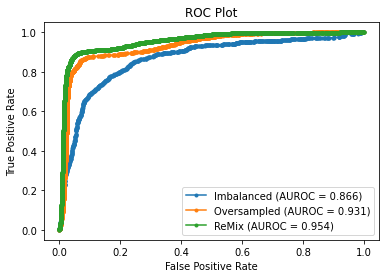


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy:
Imbalanced:  0.8780751554474182
Oversampled:  0.853054045410937
ReMix:  0.9048815506101938

F1-scores:
Imbalanced:  0.44932844932844934
Oversampled:  0.8581133240697855
ReMix:  0.9062444719617903

Runtime:
Imbalanced:  291.1404962539673
Oversampled:  589.5220291614532
ReMix:  2184.052917957306




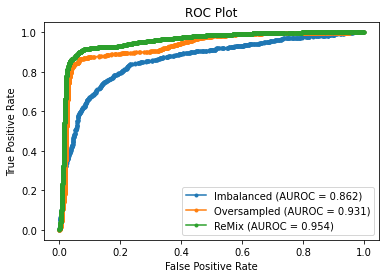


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy:
Imbalanced:  0.8672614220059476
Oversampled:  0.8487368084425967
ReMix:  0.9078427853553481

F1-scores:
Imbalanced:  0.4077201447527141
Oversampled:  0.8537867078825347
ReMix:  0.9069156167860056

Runtime:
Imbalanced:  289.2757797241211
Oversampled:  587.3569631576538
ReMix:  2141.0562772750854




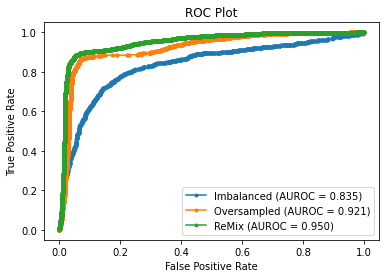


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy:
Imbalanced:  0.8413084617464179
Oversampled:  0.7804605052766229
ReMix:  0.8463747307968413

F1-scores:
Imbalanced:  0.22045152722443562
Oversampled:  0.7932540280078302
ReMix:  0.8502187226596676

Runtime:
Imbalanced:  280.18194222450256
Oversampled:  751.2467150688171
ReMix:  2353.277399778366




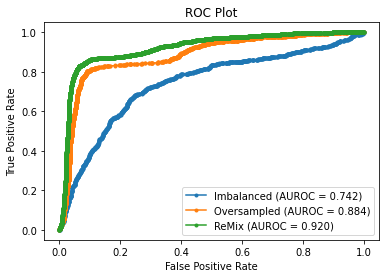


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy:
Imbalanced:  0.8356312516896458
Oversampled:  0.7283338663255516
ReMix:  0.7930725053840632

F1-scores:
Imbalanced:  0.18059299191374661
Oversampled:  0.7585618871678272
ReMix:  0.8103306464879091

Runtime:
Imbalanced:  253.15428709983826
Oversampled:  674.9592041969299
ReMix:  2381.7700209617615




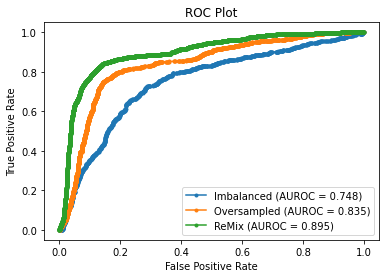

In [129]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy:")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\nRuntime:")
    print("Imbalanced: ",semi_scores[i][0][5])
    print("Oversampled: ",semi_scores[i][1][5])
    print("ReMix: ",semi_scores[i][2][5])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [82]:
file_name="s3vm_shopper.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [216]:
open_file = open("s3vm_shopper.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

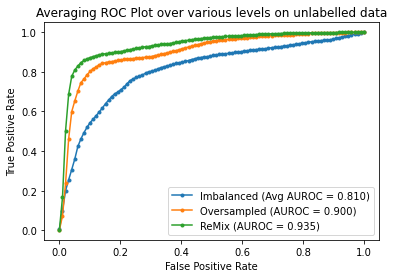

In [158]:
avg_roc(loaded_list)

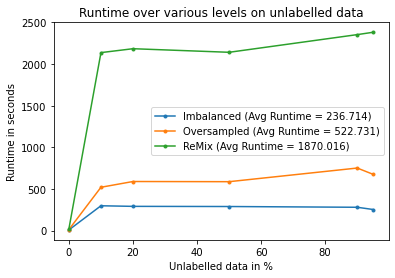

In [179]:
t_imbal = [imbal[5]]
t_over=[over[5]]
t_remix=[remix[5]]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [0,10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

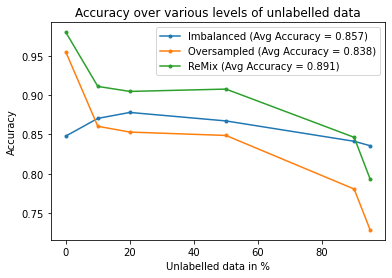

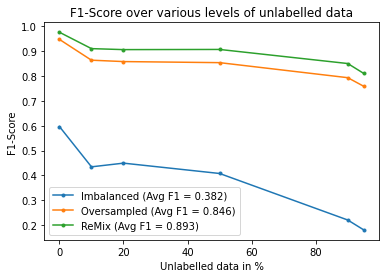

In [218]:
gplotter([0.8479318734793188],[0.9551870365511813],[0.9803052258353854],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")
gplotter([0.5967153284671532],[0.9473846153846155],[0.9761523402740702],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

### Market Dataset

In [83]:
datasets = return_datasets(pre_market,"Teenhome")

In [84]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_s3vm(datasets, "Teenhome", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  20.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  50.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  90.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  95.0
Working on Imbalanced
Working on Oversampled
Working on Remix



----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy:
Imbalanced:  0.5163690476190477
Oversampled:  0.5424460431654676
ReMix:  0.7816901408450704

F1-scores:
Imbalanced:  0.0
Oversampled:  0.15425531914893617
ReMix:  0.8208092485549133

Runtime:
Imbalanced:  0.897343635559082
Oversampled:  1.1804931163787842
ReMix:  4.787436008453369




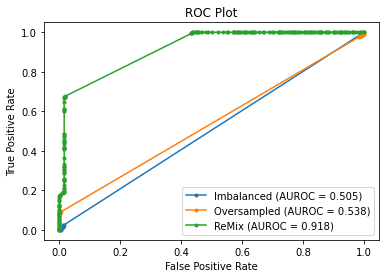


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy:
Imbalanced:  0.5163690476190477
Oversampled:  0.5309352517985612
ReMix:  0.7566510172143975

F1-scores:
Imbalanced:  0.0
Oversampled:  0.11891891891891893
ReMix:  0.8040327662255828

Runtime:
Imbalanced:  0.9365408420562744
Oversampled:  1.3905203342437744
ReMix:  5.142540454864502




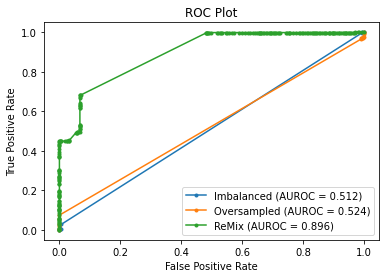


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy:
Imbalanced:  0.5163690476190477
Oversampled:  0.5251798561151079
ReMix:  0.7276995305164319

F1-scores:
Imbalanced:  0.0
Oversampled:  0.09836065573770492
ReMix:  0.634453781512605

Runtime:
Imbalanced:  1.1405985355377197
Oversampled:  1.4963669776916504
ReMix:  5.444425106048584




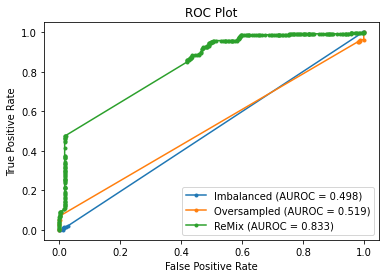


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy:
Imbalanced:  0.5163690476190477
Oversampled:  0.5064748201438849
ReMix:  0.5735524256651017

F1-scores:
Imbalanced:  0.0
Oversampled:  0.02279202279202279
ReMix:  0.3074968233799238

Runtime:
Imbalanced:  1.406205654144287
Oversampled:  1.302258014678955
ReMix:  4.95820689201355




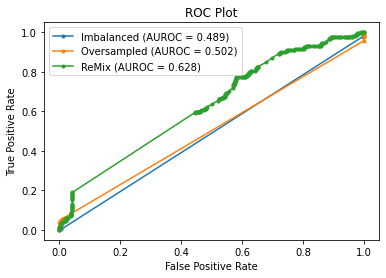


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy:
Imbalanced:  0.5163690476190477
Oversampled:  0.5035971223021583
ReMix:  0.525039123630673

F1-scores:
Imbalanced:  0.0
Oversampled:  0.017094017094017096
ReMix:  0.6560906515580737

Runtime:
Imbalanced:  1.2573165893554688
Oversampled:  1.4111518859863281
ReMix:  4.865007400512695




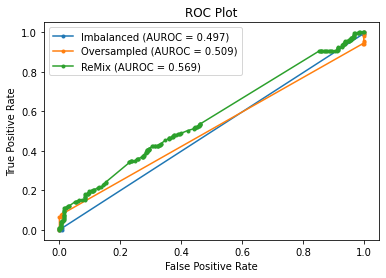

In [131]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy:")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\nRuntime:")
    print("Imbalanced: ",semi_scores[i][0][5])
    print("Oversampled: ",semi_scores[i][1][5])
    print("ReMix: ",semi_scores[i][2][5])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [86]:
file_name="s3vm_market.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [219]:
open_file = open("s3vm_market.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

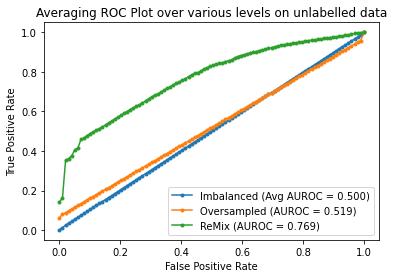

In [160]:
avg_roc(loaded_list)

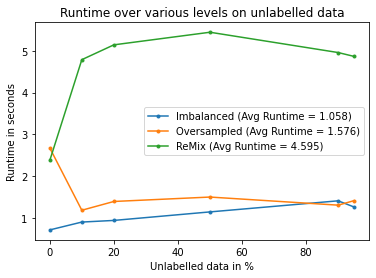

In [193]:
t_imbal = [0.7091362476348877]
t_over=[2.6722936630249023]
t_remix=[2.3741495609283447]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [0,10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

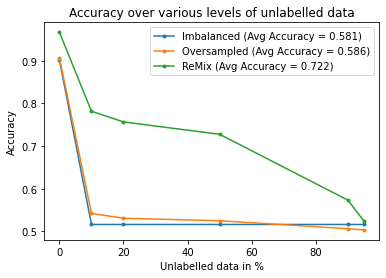

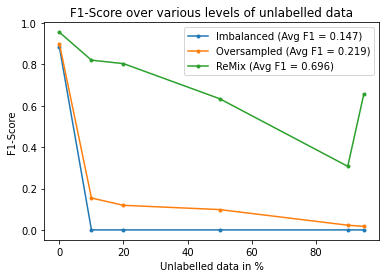

In [220]:
gplotter([0.9022321428571429],[0.9071727123451262],[0.9667791342952275],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")
gplotter([0.8833592534992224],[0.9001490312965723],[0.9557796741660203],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

### Heart Dataset

In [136]:
datasets = return_datasets(pre_heart,"target")

In [137]:
unlabelled_percent = [0.1, 0.2, 0.5, 0.9, 0.95]
semi_scores=[]
for i in range(len(unlabelled_percent)):
    print("Unlabelled percent: ",unlabelled_percent[i]*100)
    scores = get_scores_s3vm(datasets, "target", unlabelled_percent[i])
    semi_scores.append(scores)

Unlabelled percent:  10.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  20.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  50.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  90.0
Working on Imbalanced
Working on Oversampled
Working on Remix
Unlabelled percent:  95.0
Working on Imbalanced
Working on Oversampled
Working on Remix



----------------------------------------------------------------------------

Unlabelled data:  10.0 %

Accuracy:
Imbalanced:  0.6888888888888889
Oversampled:  0.5816326530612245
ReMix:  0.7883211678832117

F1-scores:
Imbalanced:  0.631578947368421
Oversampled:  0.7050359712230216
ReMix:  0.8263473053892215

Runtime:
Imbalanced:  0.0992732048034668
Oversampled:  0.09369540214538574
ReMix:  0.1603250503540039




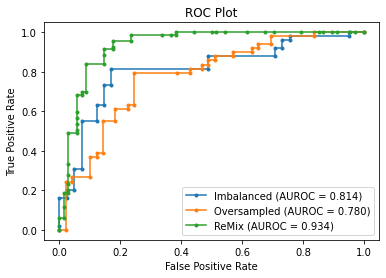


----------------------------------------------------------------------------

Unlabelled data:  20.0 %

Accuracy:
Imbalanced:  0.5555555555555556
Oversampled:  0.5816326530612245
ReMix:  0.7883211678832117

F1-scores:
Imbalanced:  0.7101449275362319
Oversampled:  0.7050359712230216
ReMix:  0.7387387387387387

Runtime:
Imbalanced:  0.07810711860656738
Oversampled:  0.13621926307678223
ReMix:  0.13795018196105957




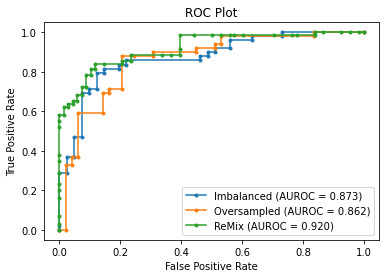


----------------------------------------------------------------------------

Unlabelled data:  50.0 %

Accuracy:
Imbalanced:  0.7111111111111111
Oversampled:  0.6326530612244898
ReMix:  0.6715328467153284

F1-scores:
Imbalanced:  0.7796610169491526
Oversampled:  0.43749999999999994
ReMix:  0.7540983606557378

Runtime:
Imbalanced:  0.12144327163696289
Oversampled:  0.10931777954101562
ReMix:  0.2298438549041748




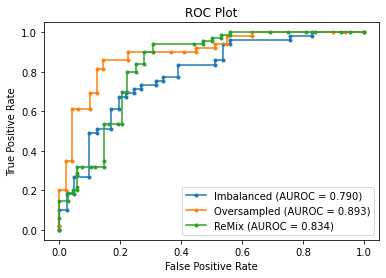


----------------------------------------------------------------------------

Unlabelled data:  90.0 %

Accuracy:
Imbalanced:  0.5555555555555556
Oversampled:  0.5102040816326531
ReMix:  0.5766423357664233

F1-scores:
Imbalanced:  0.7058823529411765
Oversampled:  0.6666666666666666
ReMix:  0.29268292682926833

Runtime:
Imbalanced:  0.11566853523254395
Oversampled:  0.1360018253326416
ReMix:  0.15617966651916504




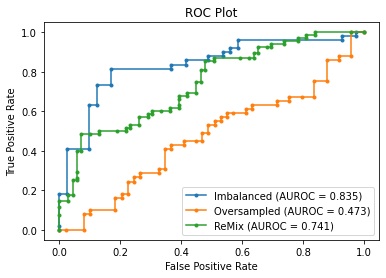


----------------------------------------------------------------------------

Unlabelled data:  95.0 %

Accuracy:
Imbalanced:  0.5
Oversampled:  0.5
ReMix:  0.4306569343065693

F1-scores:
Imbalanced:  0.6666666666666667
Oversampled:  0.0
ReMix:  0.5851063829787234

Runtime:
Imbalanced:  0.10734152793884277
Oversampled:  0.12497067451477051
ReMix:  0.1699678897857666




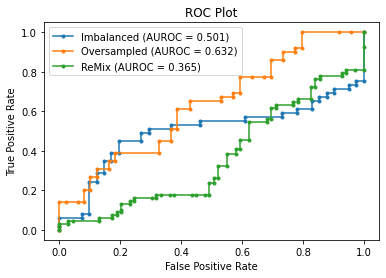

In [138]:
for i in range(len(unlabelled_percent)):
    print("\n----------------------------------------------------------------------------")
    print("\nUnlabelled data: ",unlabelled_percent[i]*100,"%")
    
    print("\nAccuracy:")
    print("Imbalanced: ",semi_scores[i][0][0])
    print("Oversampled: ",semi_scores[i][1][0])
    print("ReMix: ",semi_scores[i][2][0])
    
    print("\nF1-scores:")
    print("Imbalanced: ",semi_scores[i][0][1])
    print("Oversampled: ",semi_scores[i][1][1])
    print("ReMix: ",semi_scores[i][2][1])
    
    print("\nRuntime:")
    print("Imbalanced: ",semi_scores[i][0][5])
    print("Oversampled: ",semi_scores[i][1][5])
    print("ReMix: ",semi_scores[i][2][5])
    
    print("\n")
    
    plt.plot(semi_scores[i][0][3], semi_scores[i][0][4], marker='.', label='Imbalanced (AUROC = %0.3f)' % semi_scores[i][0][2])
    plt.plot(semi_scores[i][1][3], semi_scores[i][1][4], marker='.', label='Oversampled (AUROC = %0.3f)' % semi_scores[i][1][2])
    plt.plot(semi_scores[i][2][3], semi_scores[i][2][4], marker='.', label='ReMix (AUROC = %0.3f)' % semi_scores[i][2][2])
    # Title
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()

In [139]:
file_name="s3vm_heart.pkl"
open_file = open(file_name,"wb")
pickle.dump(semi_scores, open_file)
open_file.close()

In [221]:
open_file = open("s3vm_heart.pkl", "rb")
loaded_list = pickle.load(open_file)
open_file.close()

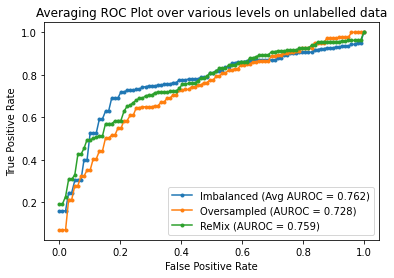

In [162]:
avg_roc(loaded_list)

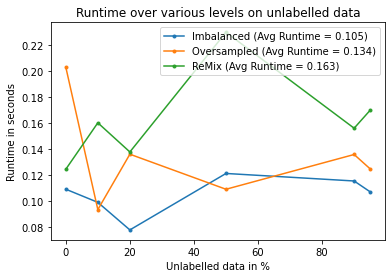

In [195]:
t_imbal = [0.10934925079345703]
t_over=[0.2030773162841797]
t_remix=[0.12466692924499512]

for i in range(len(loaded_list)):
    t_imbal.append(loaded_list[i][0][5])
    t_over.append(loaded_list[i][1][5])
    t_remix.append(loaded_list[i][2][5])

x= [0,10,20,50,90,95]

plt.plot(x, t_imbal, marker='.', label='Imbalanced (Avg Runtime = %0.3f)' % statistics.mean(t_imbal))
plt.plot(x, t_over, marker='.', label='Oversampled (Avg Runtime = %0.3f)' % statistics.mean(t_over))
plt.plot(x, t_remix, marker='.', label='ReMix (Avg Runtime = %0.3f)' % statistics.mean(t_remix))
# Title
plt.title('Runtime over various levels on unlabelled data')
# Axis labels
plt.xlabel('Unlabelled data in %')
plt.ylabel('Runtime in seconds')
# Show legend
plt.legend() # 
# Show plot
plt.show()

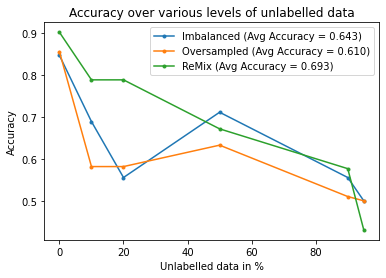

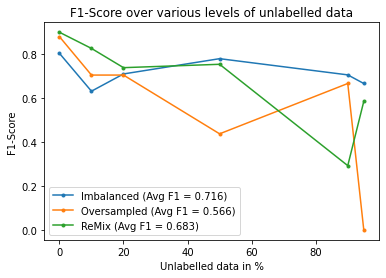

In [222]:
gplotter([0.8466666666666667],[0.8555871212121212],[0.9017874396135266],"Accuracy over various levels of unlabelled data", "Unlabelled data in %", "Accuracy", loaded_list, [0,10,20,50,90,95], 0, "Accuracy")
gplotter([0.8041237113402061],[0.8799999999999999],[0.9],"F1-Score over various levels of unlabelled data", "Unlabelled data in %", "F1-Score", loaded_list, [0,10,20,50,90,95], 1, "F1")

# Nemenyi test at alpha=0.05

In [223]:
import Orange

## Imbalanced shopper dataset

cd= 1.4822866628828582


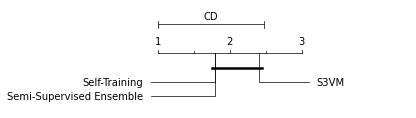

In [235]:
names = ['Self-Training','Semi-Supervised Ensemble', 'S3VM']
avranks = [1.8,1.8,2.4]
cd = Orange.evaluation.compute_CD(avranks, 5,alpha="0.05") #tested on 5 datasets 
print("cd=",cd)
Orange.evaluation.graph_ranks(avranks, names, cd=cd , width=5, textspace=1.5)
plt.show()

## Oversampled and ReMix Shopper, Imbalanced and ReMix Market, ReMix Heart

cd= 1.4822866628828582


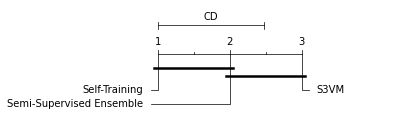

In [234]:
names = ['Self-Training','Semi-Supervised Ensemble', 'S3VM']
avranks = [1,2,3]
cd = Orange.evaluation.compute_CD(avranks, 5,alpha="0.05") #tested on 5 datasets 
print("cd=",cd)
Orange.evaluation.graph_ranks(avranks, names, cd=cd , width=5, textspace=1.5)
plt.show()

## Oversampled Market

cd= 1.4822866628828582


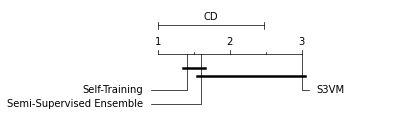

In [251]:
names = ['Self-Training','Semi-Supervised Ensemble', 'S3VM']
avranks = [1.4,1.6,3]
cd = Orange.evaluation.compute_CD(avranks, 5,alpha="0.05") #tested on 5 datasets 
print("cd=",cd)
Orange.evaluation.graph_ranks(avranks, names, cd=cd , width=5, textspace=1.5)
plt.show()

## Imbalanced Heart, Oversampled Heart

cd= 1.4822866628828582


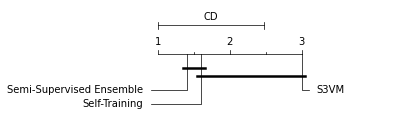

In [259]:
names = ['Self-Training','Semi-Supervised Ensemble', 'S3VM']
avranks = [1.6,1.4,3]
cd = Orange.evaluation.compute_CD(avranks, 5,alpha="0.05") #tested on 5 datasets 
print("cd=",cd)
Orange.evaluation.graph_ranks(avranks, names, cd=cd , width=5, textspace=1.5)
plt.show()

# Friedman's Test

### Shopper Imbalanced

In [227]:
self_train = [0.88104, 0.86915, 0.85536, 0.85158, 0.86482]
ss_ensemble = [0.87861, 0.88294,0.87023, 0.83536, 0.85915]
s3vm = [0.87050,0.87807,0.86726,0.84130,0.83563]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=1.2000000000000028, pvalue=0.5488116360940257)

In [228]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic < critical value, we say All algorithms perform equally")

alpha:0.05 has critical value: 6.4
since statistic < critical value, we say All algorithms perform equally


### Shopper Oversampled

In [239]:
self_train = [0.95075,
0.94403, 
0.92244, 
0.85865, 
0.83786
]
ss_ensemble = [0.93124,
0.92069,
0.89590,
0.84330,
0.78381
]
s3vm = [0.86040,
0.85305,
0.84873,
0.78046,
0.72833
]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=10.0, pvalue=0.006737946999085468)

In [240]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic > critical value, we say there is statistically significant difference")

alpha:0.05 has critical value: 6.4
since statistic > critical value, we say there is statistically significant difference


### Shopper ReMix

In [243]:
self_train = [97.412,
97.159,
95.689,
89.990,
87.944
]
ss_ensemble = [96.251,
96.080,
93.958,
88.923,
86.820
]
s3vm = [91.125,
90.488,
90.784,
84.637,
79.307
]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=10.0, pvalue=0.006737946999085468)

In [242]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic > critical value, we say there is statistically significant difference")

alpha:0.05 has critical value: 6.4
since statistic > critical value, we say there is statistically significant difference


### Imbalanced Market

In [244]:
self_train = [0.90029,
0.89732,
0.90625,
0.83630,
0.83482
]
ss_ensemble = [87.053,
86.309,
81.250 ,
82.440 ,
75.000 
]
s3vm = [0.51636,
0.51636 ,
0.51636 ,
0.51636 ,
0.51636
]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=10.0, pvalue=0.006737946999085468)

In [245]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic > critical value, we say there is statistically significant difference")

alpha:0.05 has critical value: 6.4
since statistic > critical value, we say there is statistically significant difference


### Oversampled Market

In [247]:
self_train = [0.88489,0.90503,0.87338,0.77122 ,0.69352]
ss_ensemble = [89.496,89.496,82.733,72.086 ,71.942]
s3vm = [0.54244,0.53093,0.52517,0.50647,0.50359]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=10.0, pvalue=0.006737946999085468)

In [248]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic > critical value, we say there is statistically significant difference")

alpha:0.05 has critical value: 6.4
since statistic > critical value, we say there is statistically significant difference


### ReMix Market

In [249]:
self_train = [0.94732,
0.94892,
0.93774,
0.87869,
0.80766
]
ss_ensemble = [93.948,
93.328,
92.397,
86.268,
76.183
]
s3vm = [0.78169,
0.75665,
0.72769,
0.57355,
0.52503
]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=10.0, pvalue=0.006737946999085468)

In [250]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic > critical value, we say there is statistically significant difference")

alpha:0.05 has critical value: 6.4
since statistic > critical value, we say there is statistically significant difference


### Imbalanced Heart

In [252]:
self_train = [0.81111,
0.83333 ,
0.78888 ,
0.81111 ,
0.54444 

]
ss_ensemble = [82.222 ,
83.333,
82.222,
77.777 ,
72.222 

]
s3vm = [0.68888,
0.5555,
0.71111,
0.55555,
0.5

]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=10.0, pvalue=0.006737946999085468)

In [253]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic > critical value, we say there is statistically significant difference")

alpha:0.05 has critical value: 6.4
since statistic > critical value, we say there is statistically significant difference


### Oversampled Heart

In [254]:
self_train = [0.77551 ,
0.85714 ,
0.81632 ,
0.79591 ,
0.5 

]
ss_ensemble = [78.571 ,
84.693 ,
86.734,
72.448 ,
72.448

]
s3vm = [0.58163 ,
0.58163 ,
0.63265,
0.51020,
0.5

]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=9.578947368421062, pvalue=0.00831683351100441)

In [257]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic > critical value, we say there is statistically significant difference")

alpha:0.05 has critical value: 6.4
since statistic > critical value, we say there is statistically significant difference


### ReMix Heart

In [256]:
self_train = [0.87050,
0.89928,
0.89208 ,
0.82733 ,
0.76978

]
ss_ensemble = [93.006,
88.811,
87.412 ,
80.419,
72.027 

]
s3vm = [0.78832 ,
0.78832,
0.67153,
0.57664 ,
0.43065

]

stats.friedmanchisquare(self_train,ss_ensemble,s3vm)

FriedmanchisquareResult(statistic=10.0, pvalue=0.006737946999085468)

In [258]:
print("alpha:0.05 has critical value: 6.4")
print("since statistic > critical value, we say there is statistically significant difference")

alpha:0.05 has critical value: 6.4
since statistic > critical value, we say there is statistically significant difference


In [ ]:
print("hello")